In [1]:
from collections import defaultdict
import os
import pandas as pd
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.append('../../../visualizations/')
from venn_diagram import venn3_diagram

In [2]:
# Color definitions
COLOR1 = "#FF0420"
COLOR2 = "#FF6969"
COLOR3 = "#FFCCDD"

# Font size definitions
FONT_SIZE = 15
TITLE_SIZE = 20
SUB_SIZE = 11

# Matplotlib configuration
plt.rcParams.update({
    'figure.figsize': [10, 5],
    'figure.dpi': 300,
    'figure.facecolor': 'white',
    'axes.spines.right': False,
    'axes.spines.top': False,
    'font.family': 'Arial',
    'font.size': FONT_SIZE,
    'axes.titlesize': FONT_SIZE,
    'axes.labelsize': FONT_SIZE,
    'xtick.labelsize': FONT_SIZE,
    'ytick.labelsize': FONT_SIZE,
    'legend.fontsize': SUB_SIZE,
    'legend.title_fontsize': SUB_SIZE,
    'figure.titlesize': TITLE_SIZE,
    'figure.titleweight': 'bold',
})

In [3]:
def load_csv(csv):
    pg_id = 'UNKoHLpnT_OziRiPCuX21uhgLNIJygsxuZz3A0TL-cg='
    pg_slug = 'protocol-guild'
    data = pd.read_csv(csv)
    if 'project_id' in data.columns:
        return data[data['project_id'] != pg_id]
    for col in data.columns:
        if pg_slug in data[col]:
            return data[data[col] != pg_slug]
    return data                       

PROJECTS_BY_COLLECTION = load_csv('data/projects_by_collection.csv')
PROJECTS_BY_COLLECTION = PROJECTS_BY_COLLECTION[['project_id', 'project_name', 'collection_name']]

TRANSACTIONS_BY_CHAIN = load_csv('data/transactions_by_chain.csv')
EVENTS_BY_PROJECT = load_csv('data/events_by_project.csv')

DEV_ACTIVITY_BY_PROJECT = load_csv('data/dev_activity_by_project.csv')
DEV_ACTIVITY_BY_PROJECT['bucket_month'] = DEV_ACTIVITY_BY_PROJECT['bucket_month'].apply(lambda x: x.split(' ')[0])

RF4_PROJECTS = load_csv('../retrofunding4/data/op_rf4_impact_metrics_by_project.csv')
RF3_RESULTS = (
    load_csv('../grants/2024-02-06_op_tracked_grants.csv')
    .query("tags == 'RetroPGF3'")
    [['slug','amount']]
    .dropna()
    .set_index('slug')
)

# Part 1: Cohort Analysis

Most RF3 projects were also in RF2. But most RF4 projects are new to the game.

In [4]:
# PART 1: ANALYZE ALL PROJECTS MAPPED TO A COLLECTION IN OSO

collections = (
    PROJECTS_BY_COLLECTION
    .groupby('collection_name')['project_id']
    .agg(lambda x: list(set(x)))
    .to_dict()
)
projects = (
    PROJECTS_BY_COLLECTION[['project_id', 'project_name']]
    .drop_duplicates()
    .set_index('project_id')['project_name']
    .to_dict()
)

print("Total Collections in OSO:", len(collections))
print("Total Projects is OSO:", len(projects))

print("\n***********************\n")

# PART 2: ASSIGN RETROFUNDING PROJECTS TO A COHORT

rf_collections = {'op-rpgf1', 'op-rpgf2', 'op-rpgf3'}
cohorts = defaultdict(list)
iterator = PROJECTS_BY_COLLECTION.groupby('project_id')['collection_name'].agg(set)

for project_id, collection_set in iterator.items():
    in_rf4 = 'op-retrofunding-4' in collection_set
    in_past_rfs = bool(collection_set & rf_collections)
    
    if in_rf4:
        cohort_key = 'Returning RF project' if in_past_rfs else 'First-time RF project'
    else:
        cohort_key = 'Past RF project' if in_past_rfs else 'Never received RF'
        
    cohorts[cohort_key].append(project_id)

cohorts = dict(cohorts) 
project_cohort_mapping = {project_id: cohort for cohort, projects in cohorts.items() for project_id in projects}
for cohort, project_list in cohorts.items():
    print(f"{cohort}: {len(project_list)}")
    
rf_projects = set(
    cohorts['Returning RF project']
    + cohorts['First-time RF project']
    + cohorts['Past RF project']
)
print("\nTotal RF projects in OSO:", len(rf_projects))    

Total Collections in OSO: 23
Total Projects is OSO: 1506

***********************

Never received RF: 960
Past RF project: 316
First-time RF project: 176
Returning RF project: 54

Total RF projects in OSO: 546


(<Figure size 1440x1440 with 1 Axes>, <Axes: >)

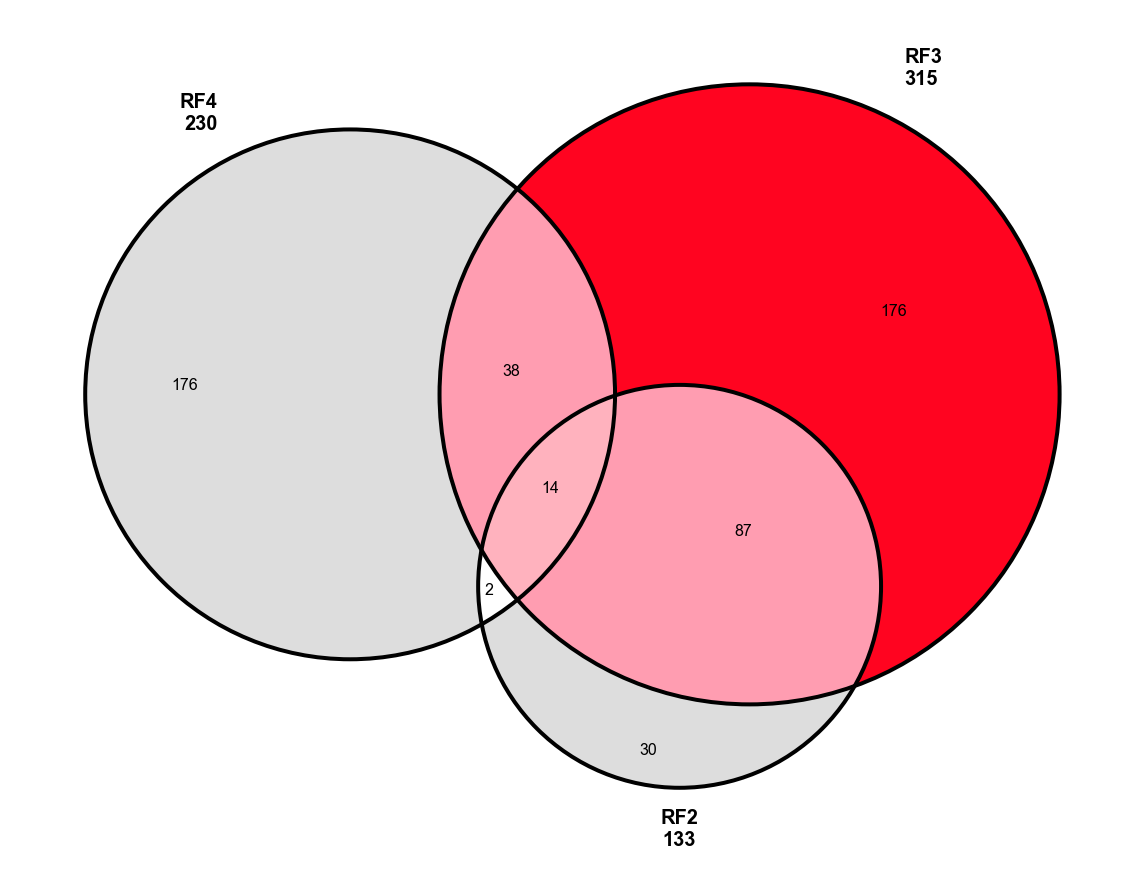

In [5]:
venn3_diagram(
    subsets=[
        set(collections['op-retrofunding-4']),
        set(collections['op-rpgf3']),
        set(collections['op-rpgf2'])
    ],
    labels=[
        f"RF4\n{len(collections['op-retrofunding-4'])}",
        f"RF3\n{len(collections['op-rpgf3'])}",
        f"RF2\n{len(collections['op-rpgf2'])}"
    ],
    colors=['#DDD', COLOR1, '#DDD']
)

## Part 2: Trends in developer activity before/after RF3

What has been the change in developer activity 6 months before and after Retro Funding 3?

1. All participants
2. By cohort
3. Compared to synthetic control group
4. By amount of funding received in RF3

In [6]:
# HELPER FUNCTIONS

def assign_6_month_interval(date):
    year = date.year
    month = date.month
    
    if 12 <= month or month <= 5:
        if month <= 5:
            interval_start = pd.Timestamp(year=year-1, month=12, day=1)
        else:
            interval_start = pd.Timestamp(year=year, month=12, day=1)
    else: 
        interval_start = pd.Timestamp(year=year, month=6, day=1)
    
    interval_end = interval_start + pd.DateOffset(months=6) - pd.DateOffset(days=1)
    return f'{interval_start.strftime("%Y-%m")} to {interval_end.strftime("%Y-%m")}'

def growth_rate(monthly_values):
    n = len(monthly_values) - 1
    years = n / 12
    start_value = monthly_values.iloc[0]
    end_value = monthly_values.iloc[-1]
    cagr = (end_value / start_value) ** (1 / years) - 1
    return cagr

def fulltime_active_devs(dev_days_with_commits):
    return (
        min(dev_days_with_commits/10, 1)
        if dev_days_with_commits > 1
        else 0
    )

In [7]:
# CREATE A FILTERED DATAFRAME OF 'FULLTIME ACTIVE DEVELOPERS' BY PROJECT

dev_df = DEV_ACTIVITY_BY_PROJECT.copy()
dev_df = dev_df[dev_df['bucket_month'] >= '2022-01-01']
dev_df['cohort'] = dev_df['project_id'].map(project_cohort_mapping)
dev_df['bucket_month'] = pd.to_datetime(dev_df['bucket_month'])
dev_df['project_name'] = dev_df['project_id'].map(projects)
dev_df['6_month_interval'] = dev_df['bucket_month'].apply(assign_6_month_interval)
dev_df['fulltime_active_dev'] = dev_df['num_days'].apply(fulltime_active_devs)
dev_df.dropna(inplace=True)
dev_df.head(2)

project_id bucket_month  \
0  BU4je0rBaW7jy0kU_JDLW7p-pDxaVCMu4loDmU7q35E=   2022-06-01   
1  6kF9vB0xEfun7IZv4f3exhhtPDzgzN-5G9MbCQrIKj0=   2022-06-01   

                               from_artifact_id  num_days  num_commits  \
0  xbttWR88pz2yB_2sfgYZZkmW5cmzmw058cjDVjlbBeI=        10           78   
1  H4cdyq_GPKt_bpNvhOUmSToWAqV0YhAZ4PmIQLhVgSw=         6           11   

              cohort project_name    6_month_interval  fulltime_active_dev  
0  Never received RF          w3c  2022-06 to 2022-11                  1.0  
1  Never received RF     bitquery  2022-06 to 2022-11                  0.6

Text(0.0, 1.0, 'Change in developer activity for projects in RF3\n')

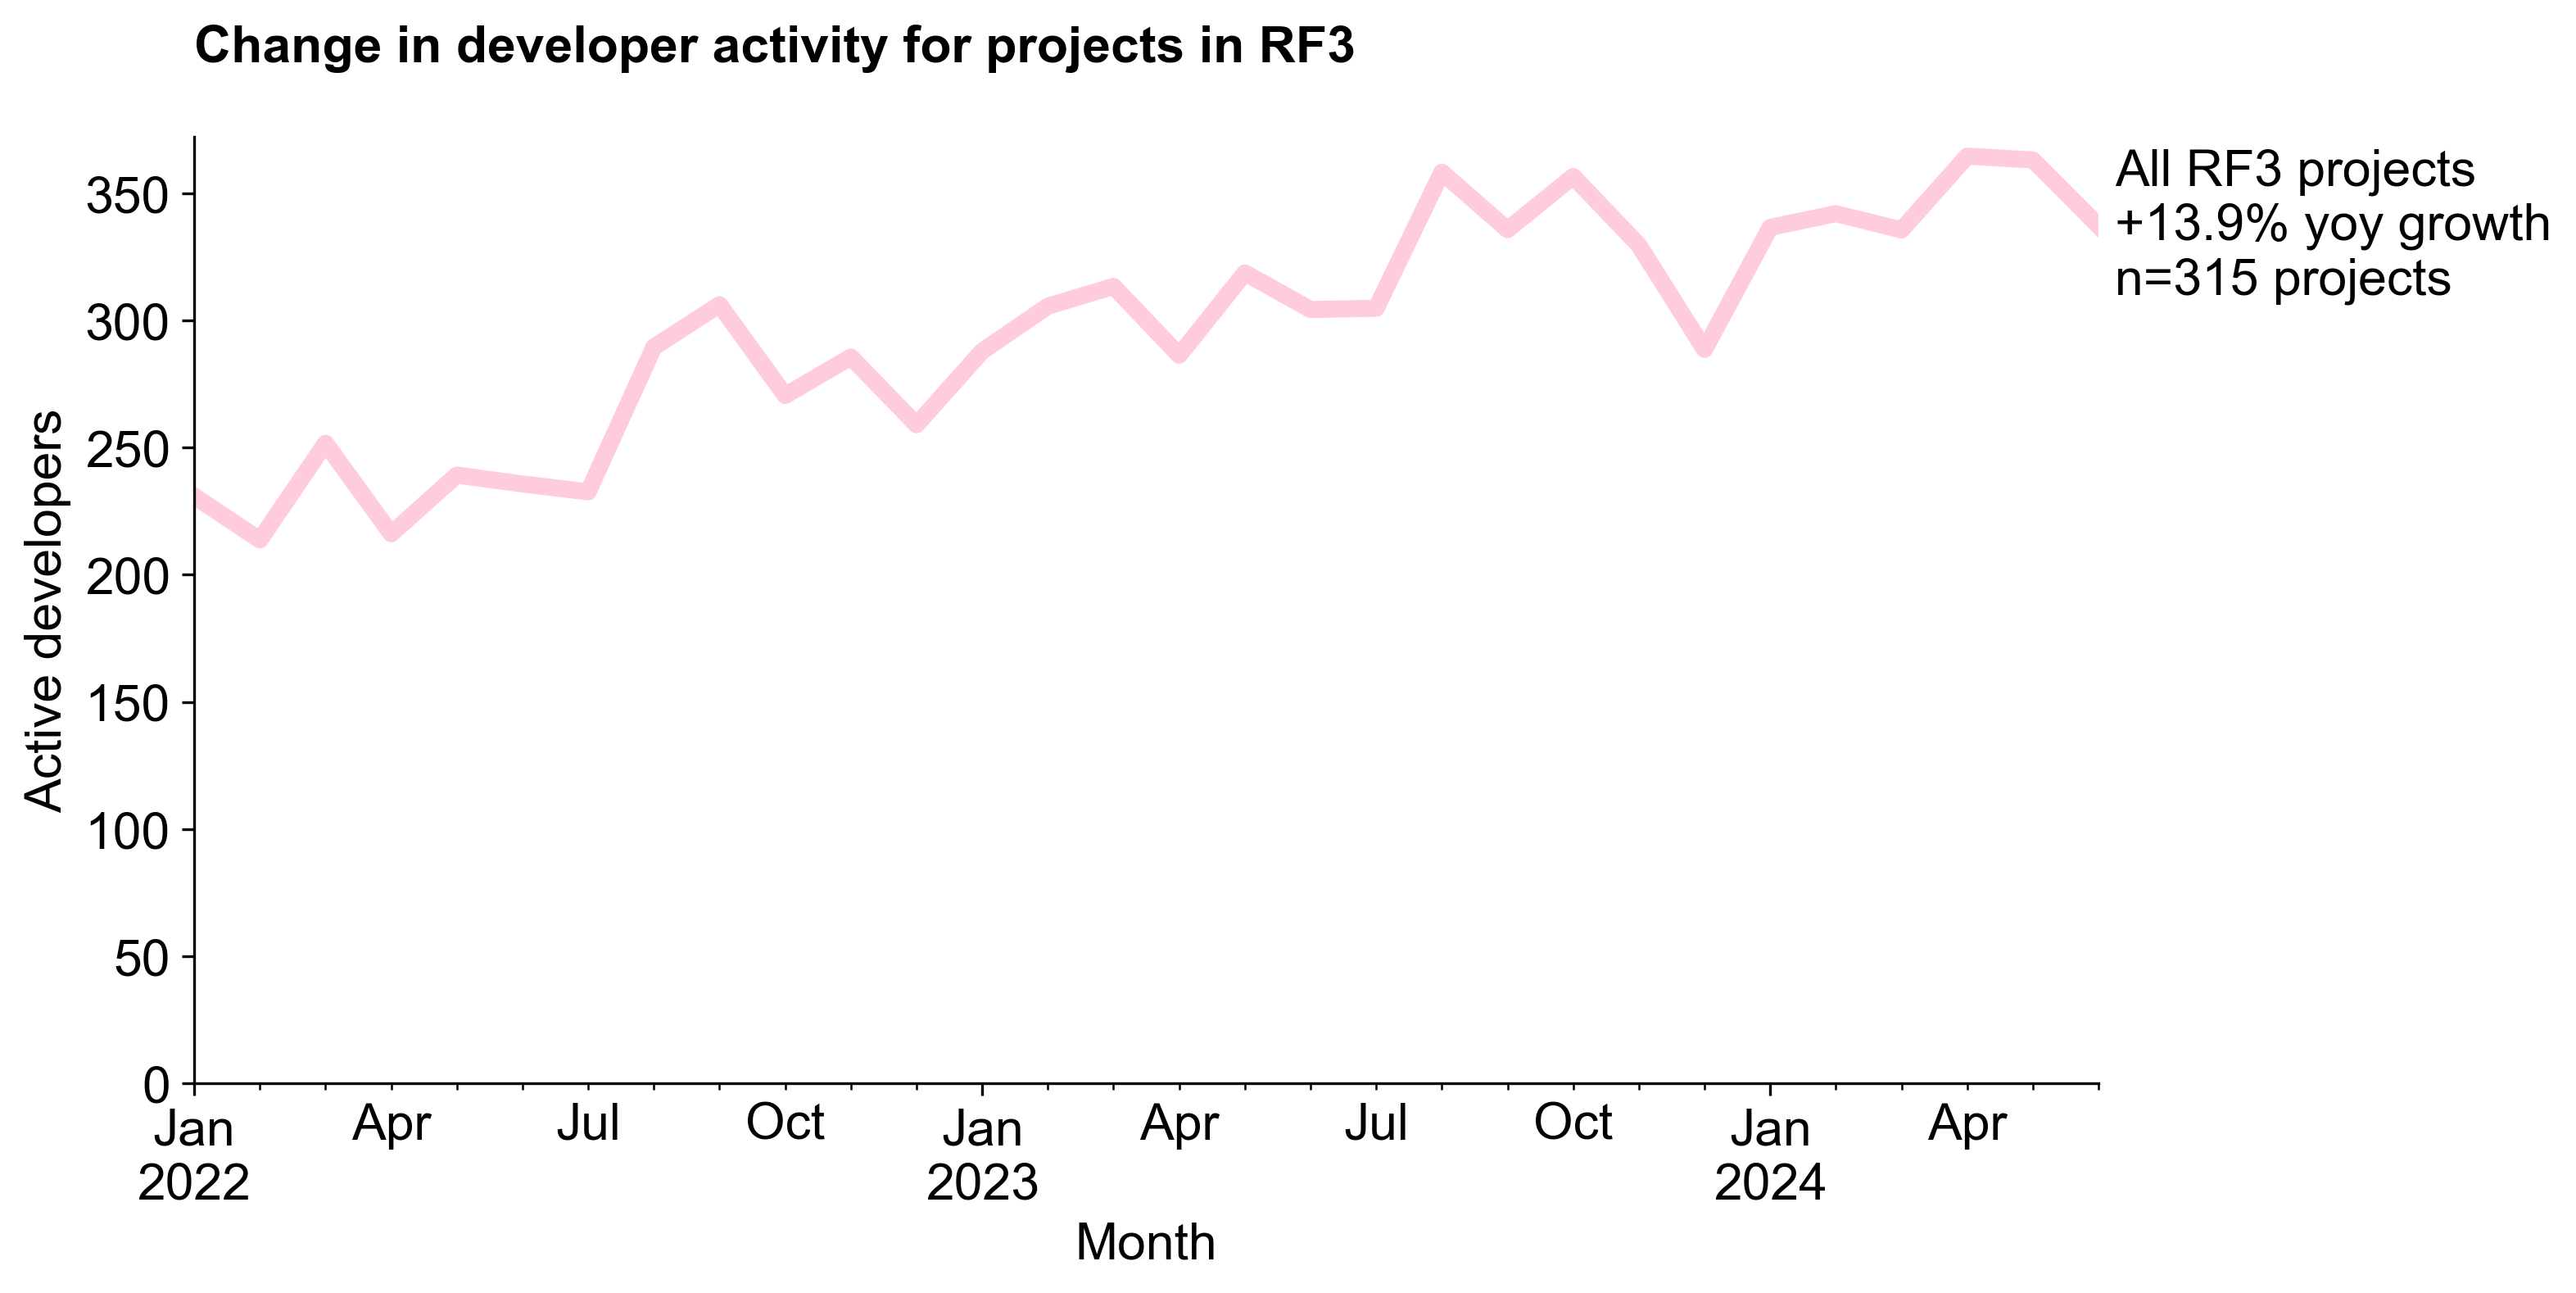

In [8]:
fig, ax = plt.subplots()
dev_dff = (
    dev_df[dev_df['project_id'].isin(collections['op-rpgf3'])]
    .groupby('bucket_month')['fulltime_active_dev']
    .sum()
)
dev_dff.plot(kind='line', color=COLOR3, lw=5, ax=ax)

label = 'All RF3 projects'
g = growth_rate(dev_dff[-14:-1])
n = len(collections['op-rpgf3'])
gstr = f"{g:+.1%}"
label = f"{label}\n{gstr} yoy growth\nn={n} projects"
xmax = ax.get_xlim()[-1] + .25
ax.text(x=xmax, y=dev_dff.iloc[-1], s=label, va='center', size=FONT_SIZE)

ax.set_ylim(0,)
ax.set_ylabel("Active developers")
ax.set_xlabel("Month")
ax.set_title("Change in developer activity for projects in RF3\n", loc='left', weight='bold')

Text(0.0, 1.0, 'Change in developer activity for projects in RF3\n')

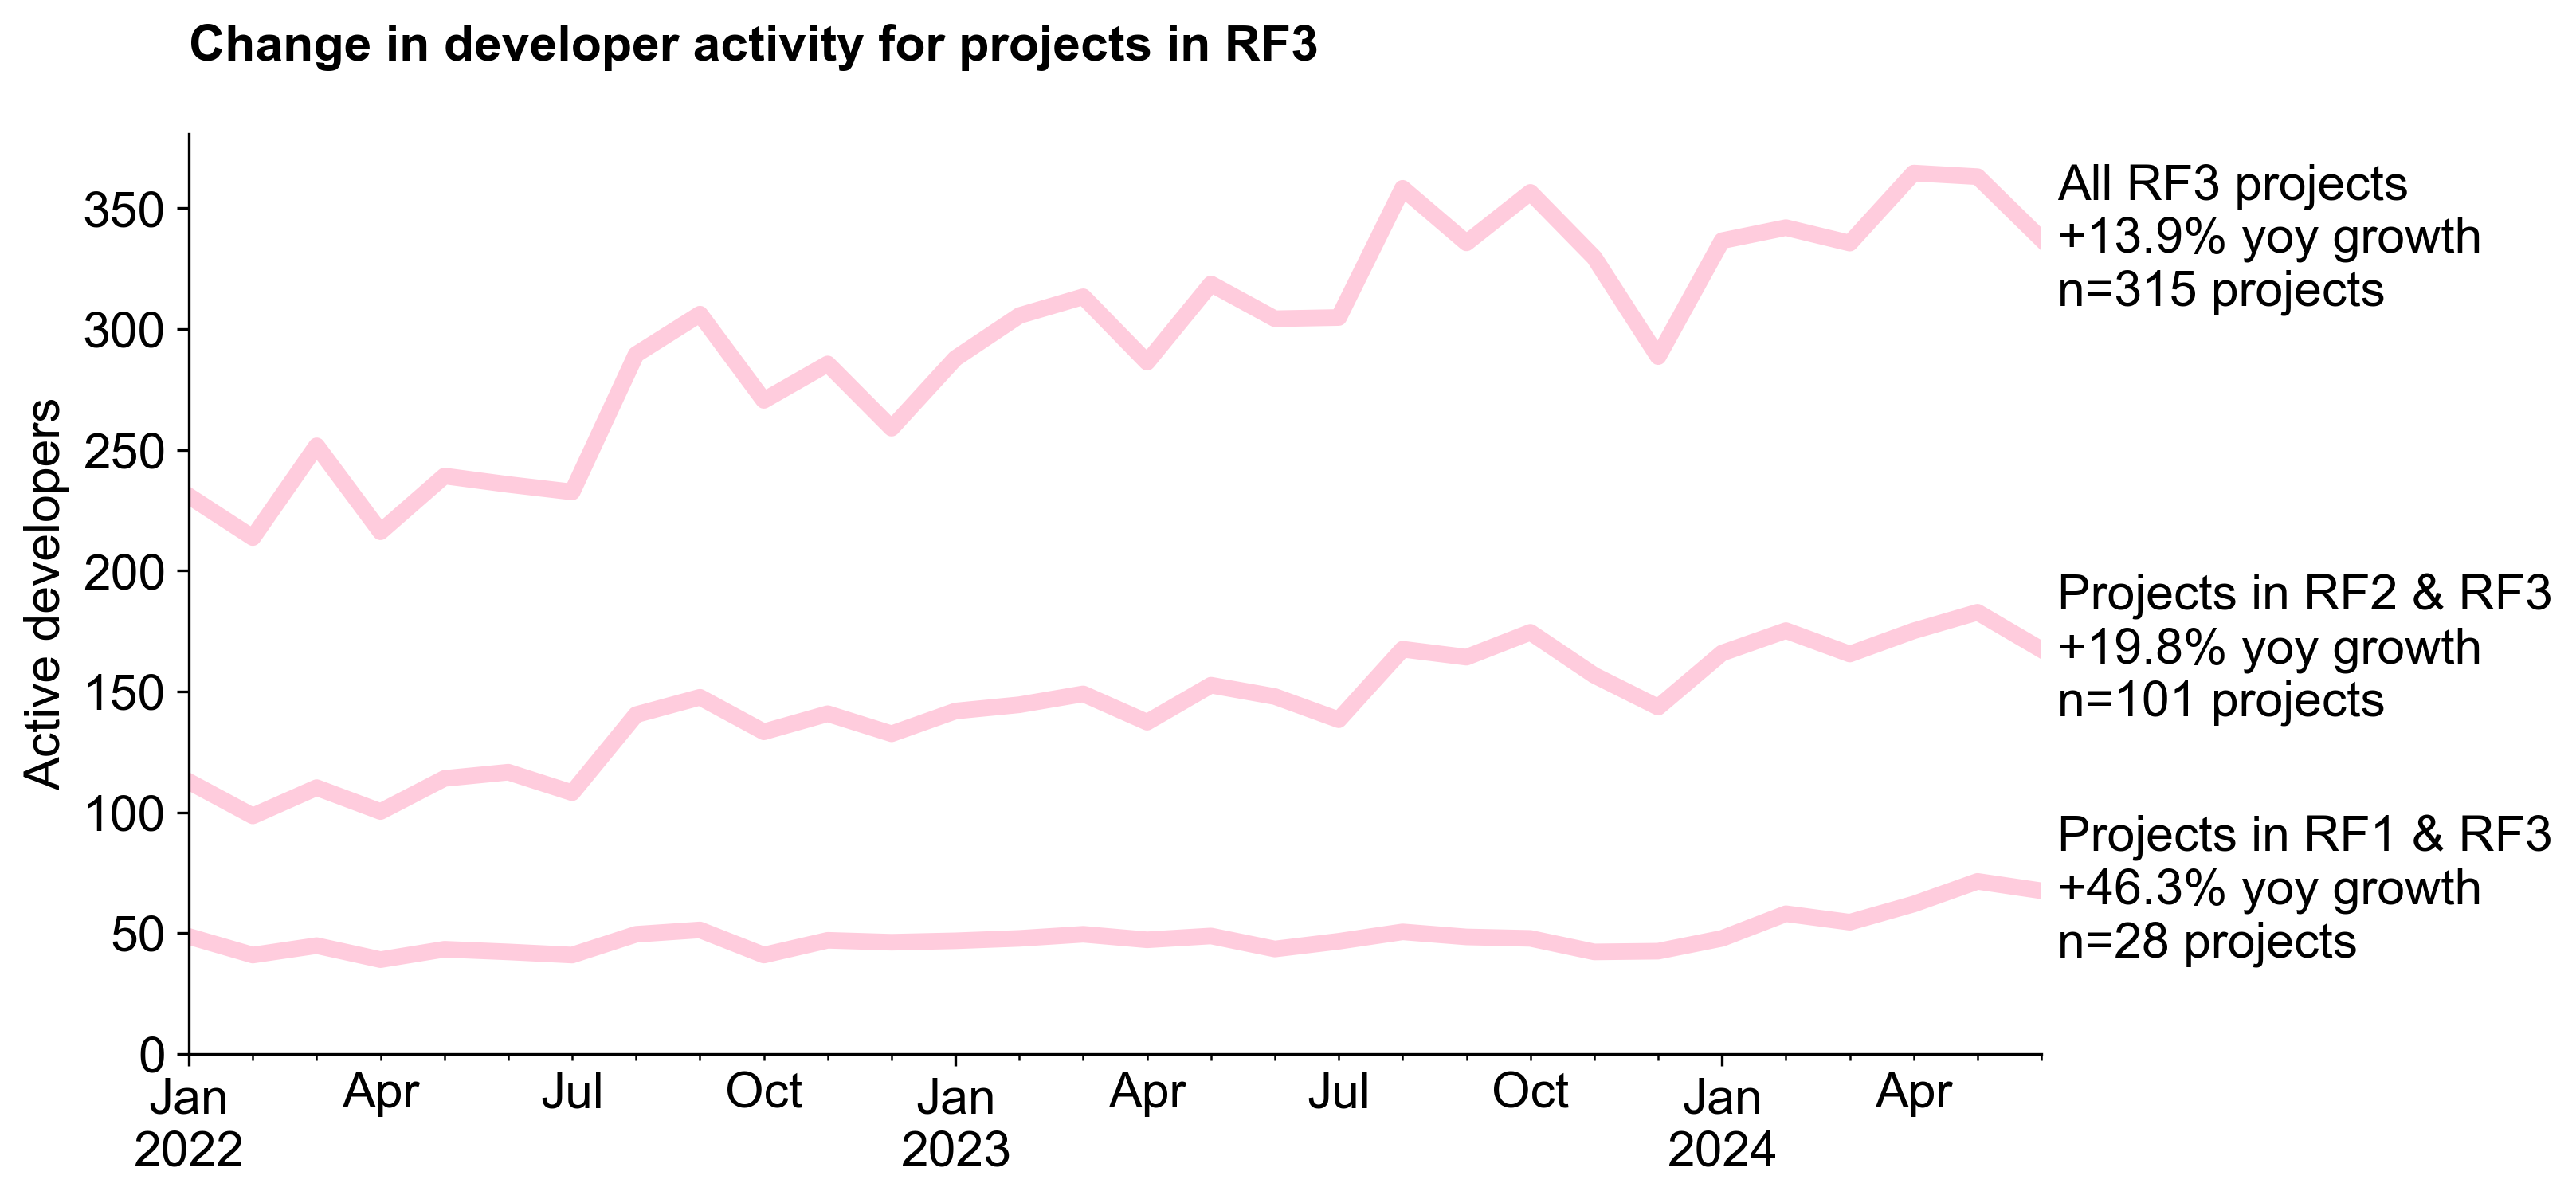

In [9]:
fig, ax = plt.subplots()
for collection in rf_collections:
    subcollection = set(collections.get(collection)).intersection(set(collections['op-rpgf3']))
    dev_dff = (
        dev_df[dev_df['project_id'].isin(subcollection)]
        .groupby('bucket_month')['fulltime_active_dev']
        .sum()
    )
    dev_dff.plot(kind='line', color=COLOR3, lw=5, ax=ax)
    
    label = 'All RF3 projects'
    if collection != 'op-rpgf3':
        label = f"Projects in RF{collection[-1]} & RF3"
    g = growth_rate(dev_dff[-14:-1])
    n = len(subcollection)
    gstr = f"{g:+.1%}"
    label = f"{label}\n{gstr} yoy growth\nn={n} projects"
    xmax = ax.get_xlim()[-1] + .25
    ax.text(x=xmax, y=dev_dff.iloc[-1], s=label, va='center', size=FONT_SIZE)
    
ax.set_ylim(0,)
ax.set_ylabel("Active developers")
ax.set_xlabel("")
ax.set_title("Change in developer activity for projects in RF3\n", loc='left', weight='bold')

Text(0.0, 1.0, 'Change in developer activity by cohort\n')

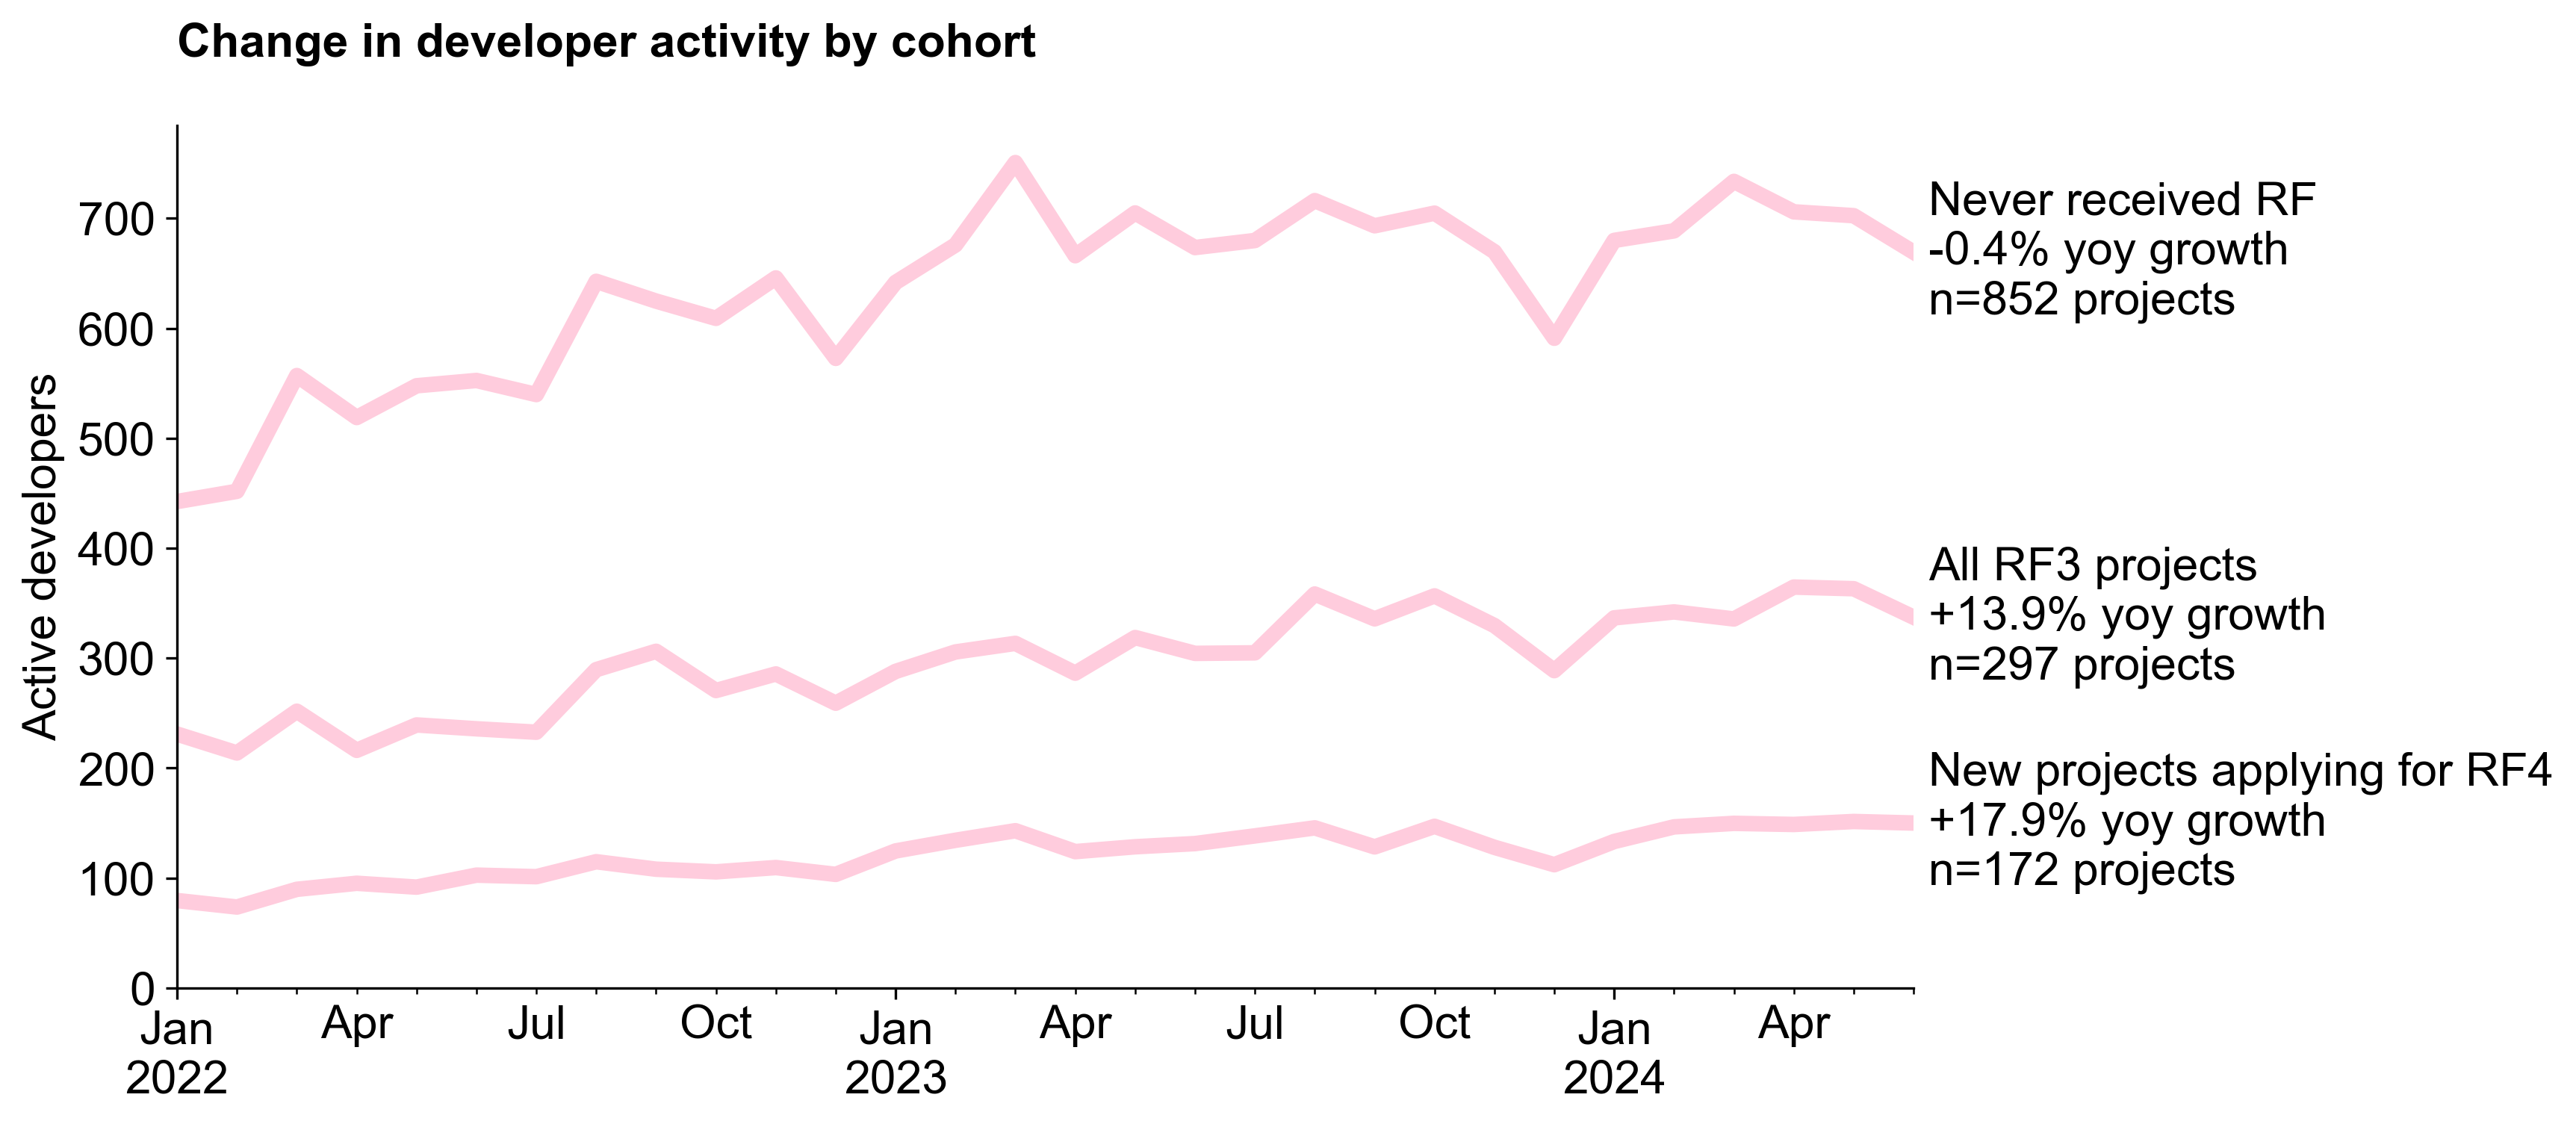

In [10]:
fig, ax = plt.subplots()
comps = [
    {
        'filter': dev_df[dev_df['project_id'].isin(collections['op-rpgf3'])],
        'label': 'All RF3 projects'
    },
    {
        'filter': dev_df[dev_df['cohort']=='Never received RF'],
        'label': 'Never received RF'
    },
    {
        'filter': dev_df[dev_df['cohort']=='First-time RF project'],
        'label': 'New projects applying for RF4'
    }
]
for comp in comps:
    dev_dff = comp['filter'].groupby('bucket_month')['fulltime_active_dev'].sum()
    dev_dff.plot(kind='line', color=COLOR3, lw=5, ax=ax)
    
    label = comp['label']
    g = growth_rate(dev_dff[-14:-1])
    n = comp['filter']['project_id'].nunique()
    gstr = f"{g:+.1%}"
    label = f"{label}\n{gstr} yoy growth\nn={n} projects"
    xmax = ax.get_xlim()[-1] + .25
    ax.text(x=xmax, y=dev_dff.iloc[-1], s=label, va='center', size=FONT_SIZE)
    
ax.set_ylim(0,)
ax.set_ylabel("Active developers")
ax.set_xlabel("")
ax.set_title("Change in developer activity by cohort\n", loc='left', weight='bold')

In [11]:
# CREATE A NEW COMPARISON FOR 6 MONTHS BEFORE/AFTER RF3

BEFORE = '2023-06 to 2023-11'
AFTER = '2023-12 to 2024-05'

delta_df = dev_df.pivot_table(
    index='project_id',
    columns='6_month_interval',
    values='fulltime_active_dev',
    aggfunc='sum',
    fill_value=0
)
delta_df = delta_df[delta_df[BEFORE] > 0]
delta_df['delta'] = delta_df[AFTER]/6 - delta_df[BEFORE]/6

delta_df['is_rf_project'] = ~delta_df.index.isin(cohorts['Never received RF'])
delta_df['project_name'] = delta_df.index.map(projects)

Text(0.0, 1.0, 'Monthly active developers by project 6 months before and after RF3\n')

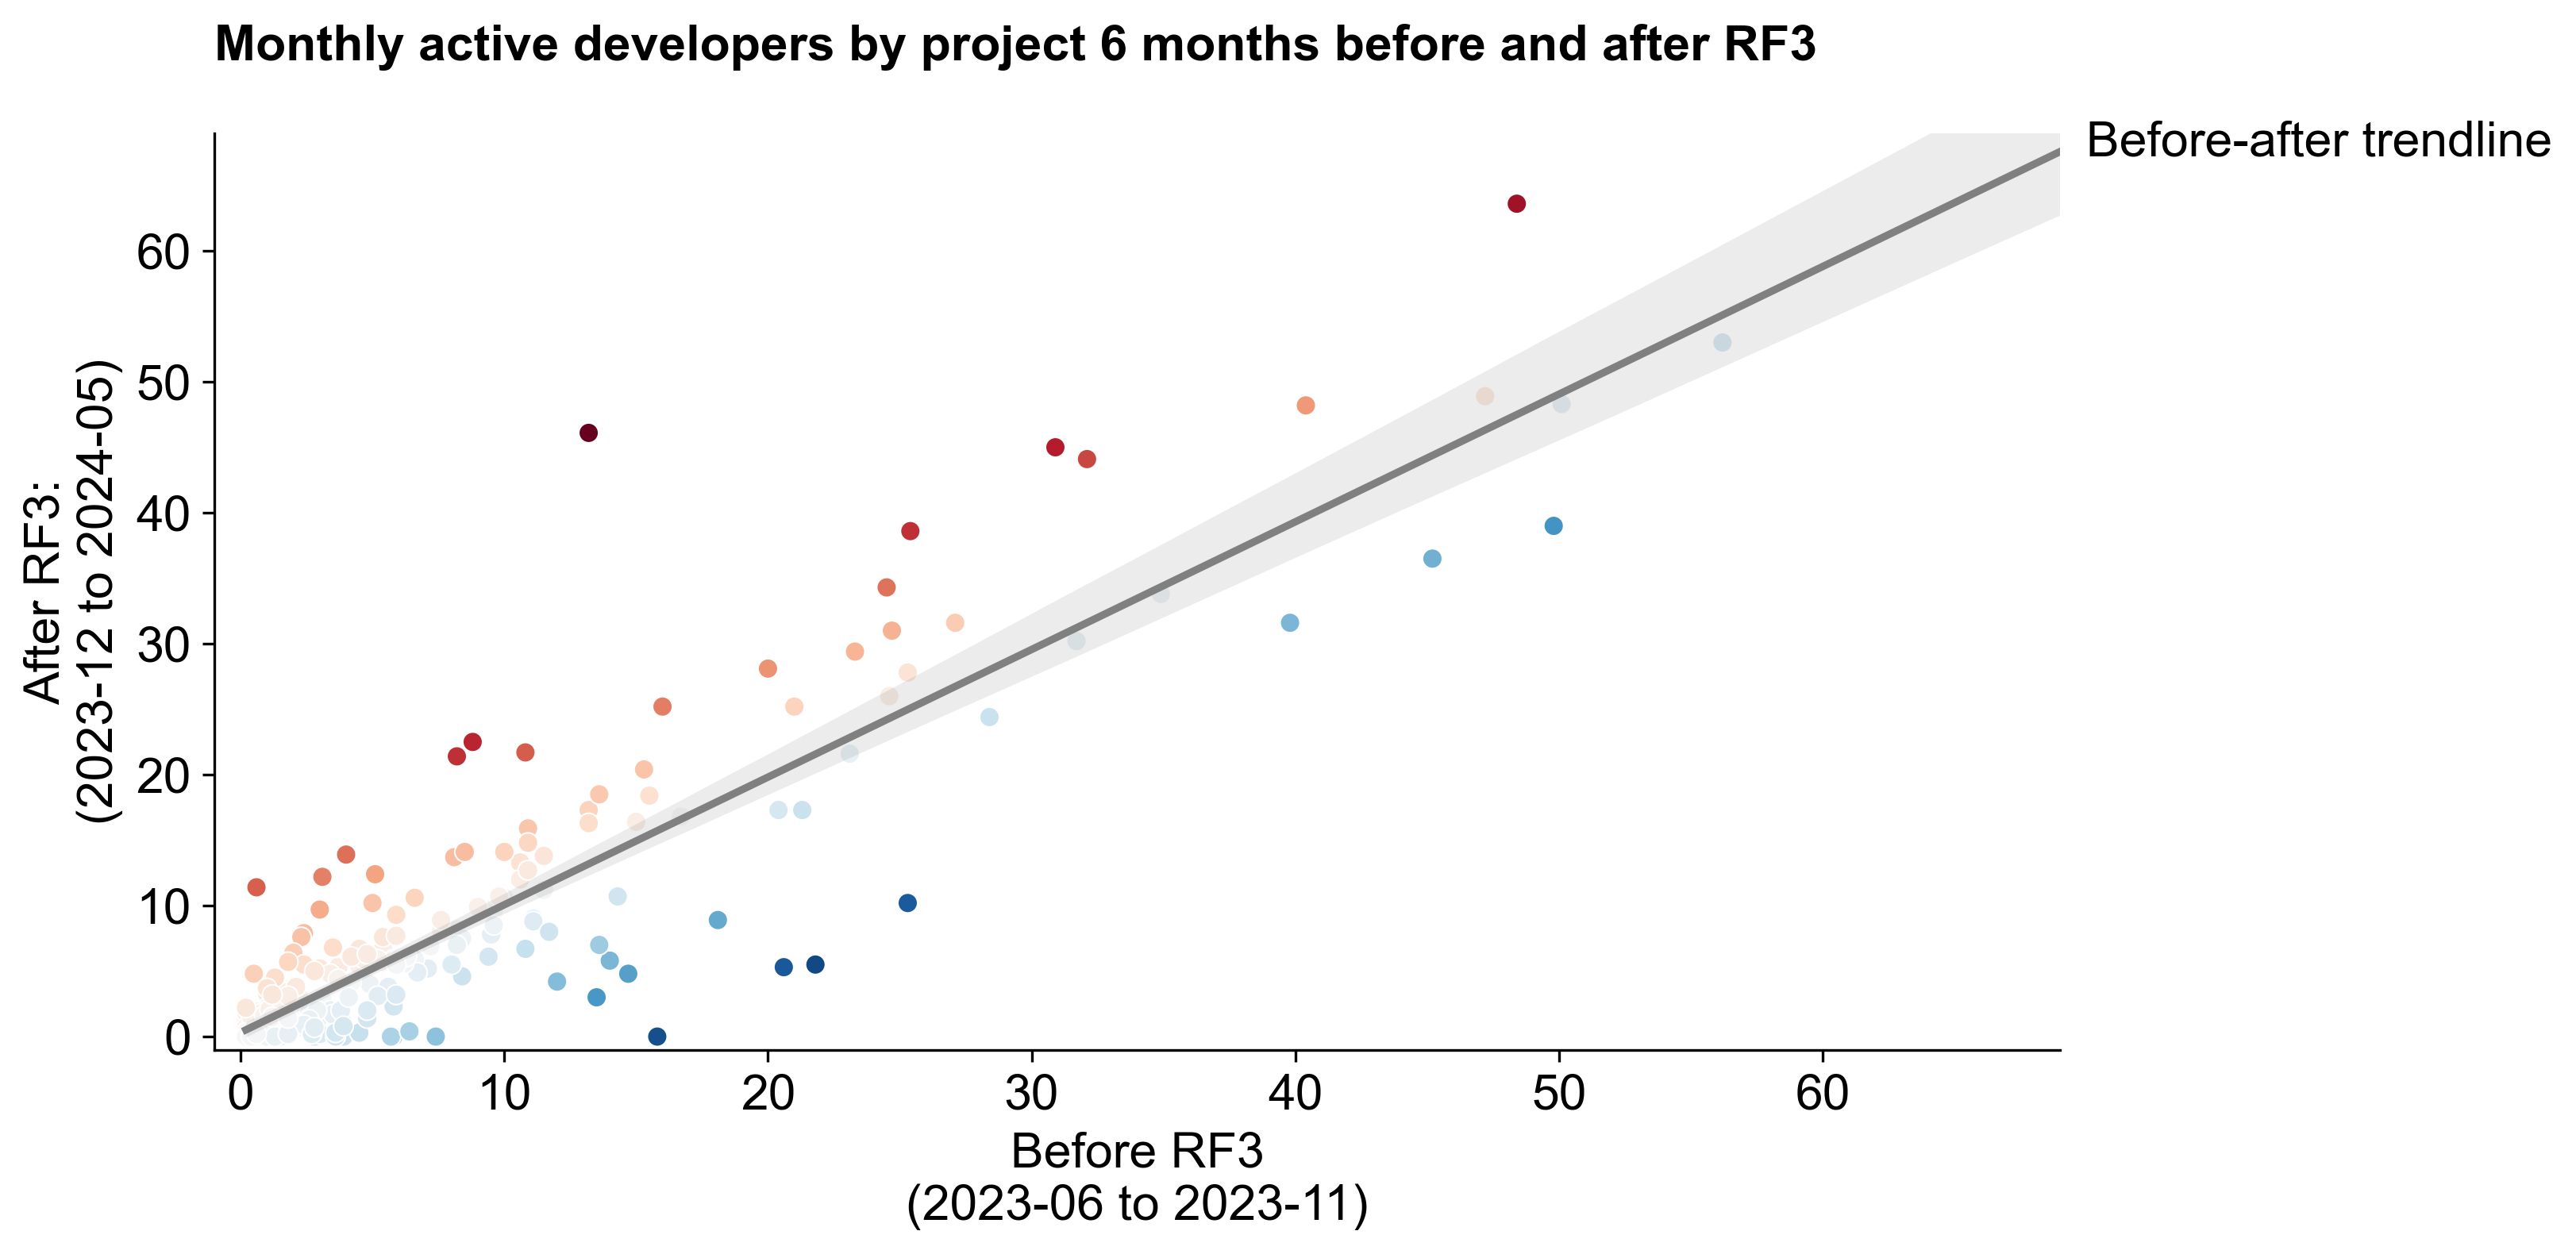

In [12]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=delta_df.reindex(collections['op-rpgf3']),
    x=BEFORE,
    y=AFTER,
    hue='delta',
    palette='RdBu_r',
    hue_norm=(-3,3),
    legend=False,
    ax=ax
)
sns.regplot(
    data=delta_df.reindex(collections['op-rpgf3']),
    x=BEFORE,
    y=AFTER,
    scatter=False,
    ax=ax,
    line_kws={'color': 'gray'}
)
ax.set_xlim(-1,69)
ax.set_ylim(-1,69)

ax.set_xlabel(f"Before RF3\n({BEFORE})")
ax.set_ylabel(f"After RF3:\n({AFTER})")
ax.text(x=70, y=70, s='Before-after trendline', va='top', size=FONT_SIZE)
ax.set_title("Monthly active developers by project 6 months before and after RF3\n", loc='left', weight='bold')

Text(0.0, 1.0, 'Monthly active developers by project 6 months before and after RF3\n')

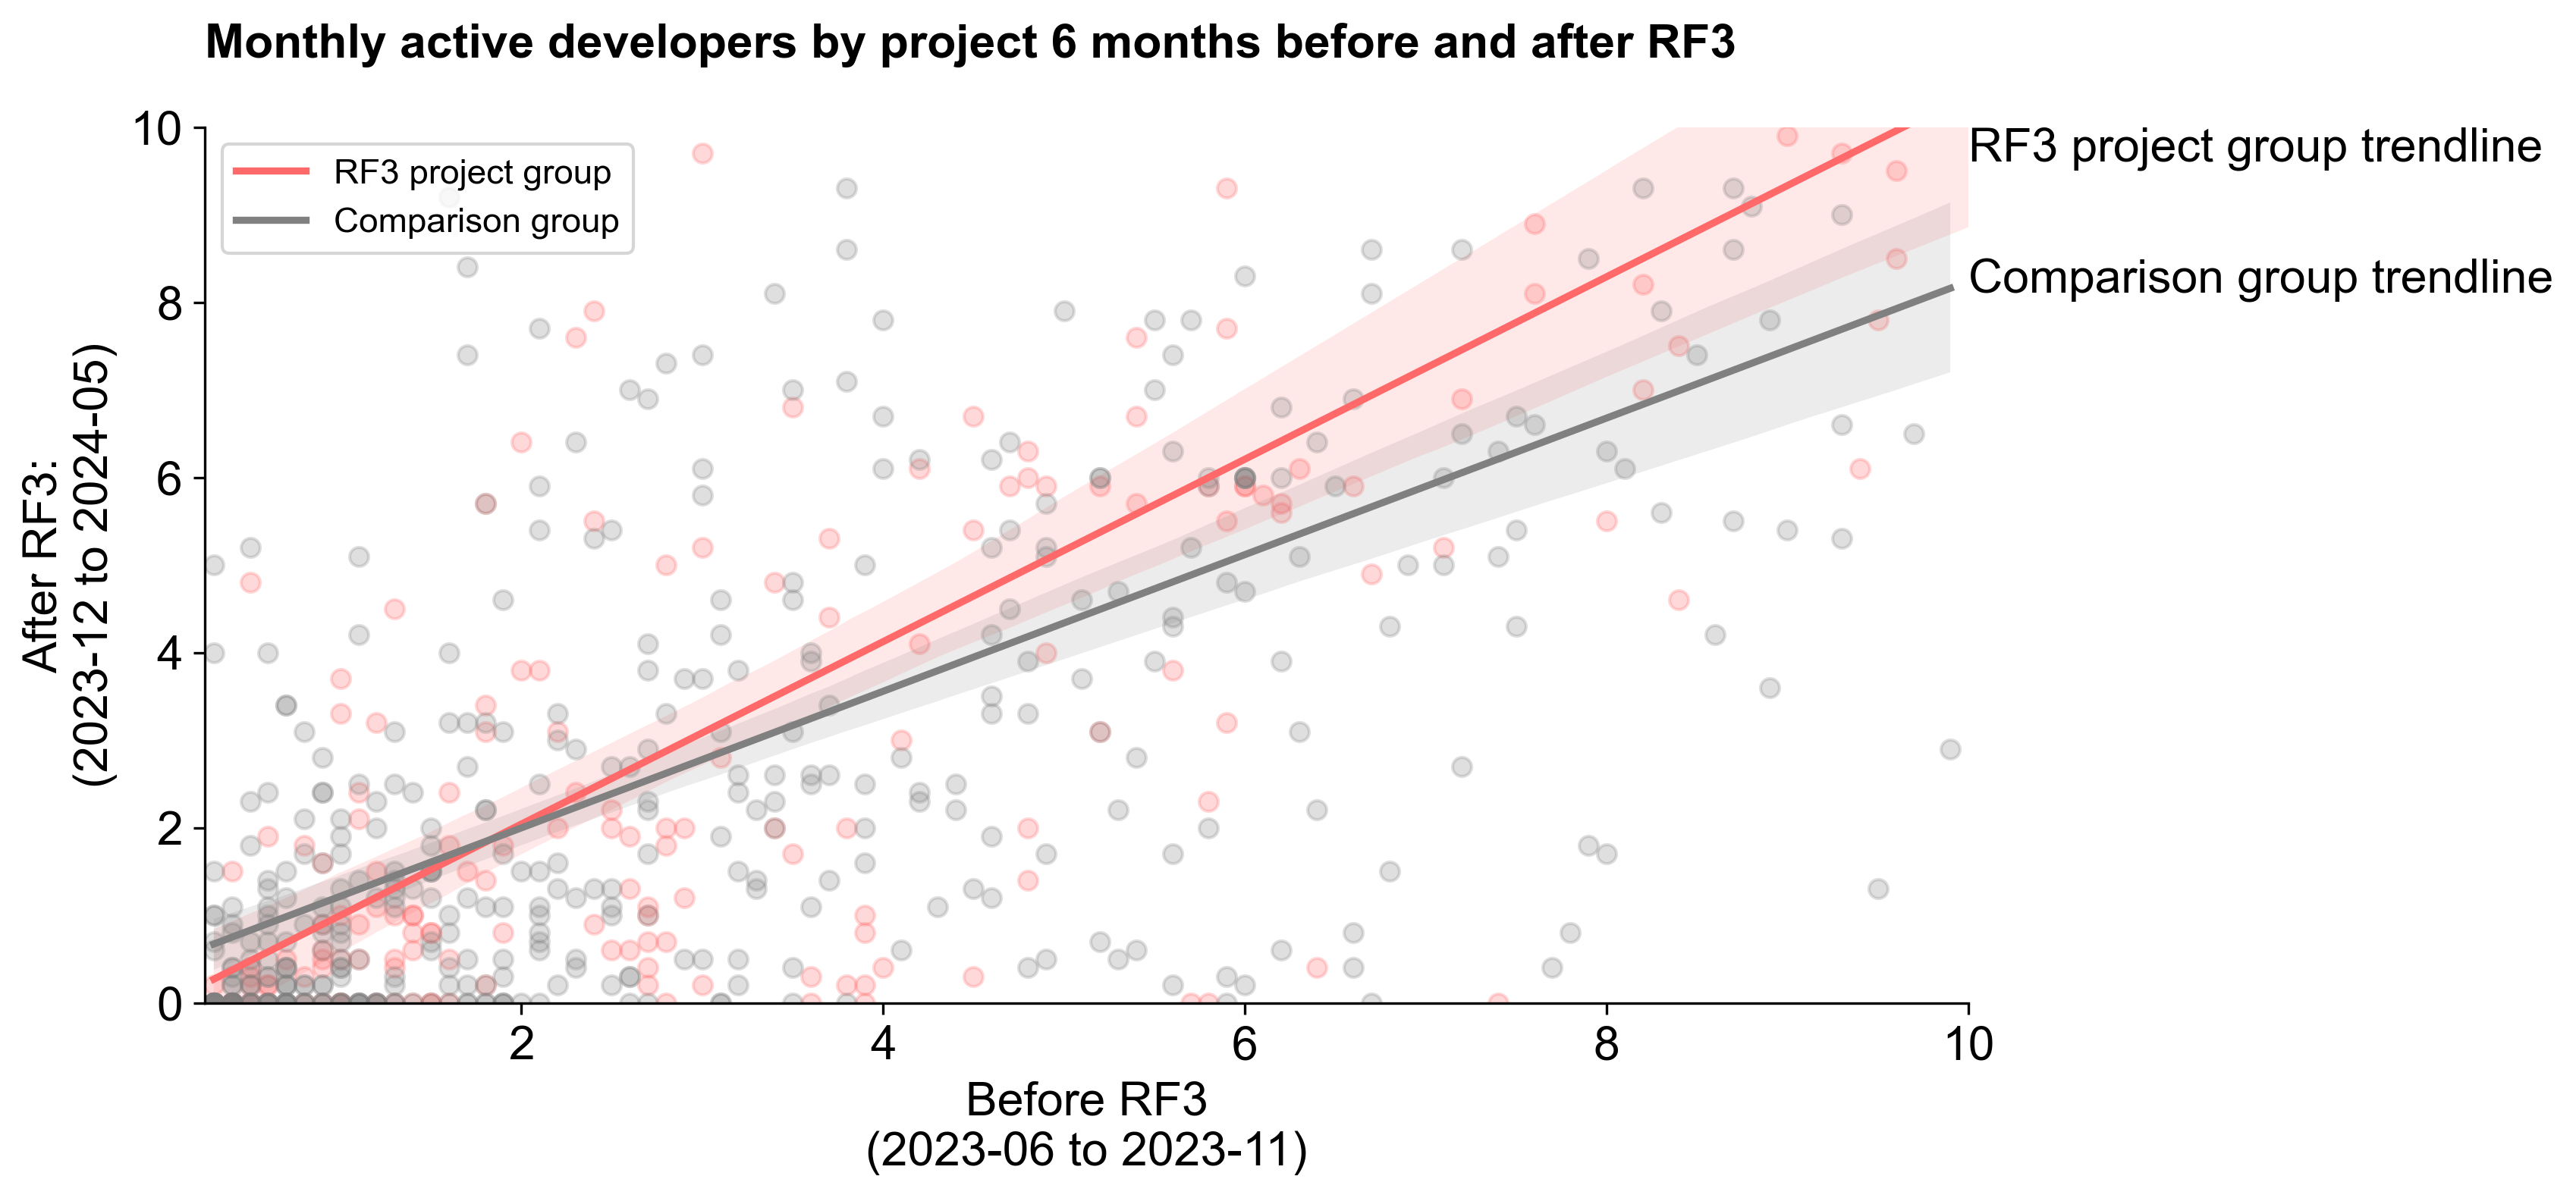

In [13]:
delta_dff = delta_df[delta_df[BEFORE].between(0.25,10)]
treatment = delta_dff[delta_dff.index.isin(collections['op-rpgf3'])]
control = delta_dff[delta_dff['is_rf_project']==False]

fig, ax = plt.subplots()
sns.regplot(
    data=treatment,
    x=BEFORE,
    y=AFTER,
    scatter=True,
    color=COLOR2,
    line_kws={'color': COLOR2, 'label': 'RF3 project group'},
    scatter_kws={'alpha': .25},
    ax=ax
)
sns.regplot(
    data=control,
    x=BEFORE,
    y=AFTER,
    scatter=True,
    color='gray',
    line_kws={'color': 'gray', 'label': 'Comparison group'},
    scatter_kws={'alpha': .25},
    ax=ax
)

ax.set_xlim(0.25,10)
ax.set_ylim(0,10)
ax.legend(loc='upper left')

ax.set_xlabel(f"Before RF3\n({BEFORE})")
ax.set_ylabel(f"After RF3:\n({AFTER})")
ax.text(x=10, y=10, s='RF3 project group trendline', va='top', size=FONT_SIZE)
ax.text(x=10, y=8.5, s='Comparison group trendline', va='top', size=FONT_SIZE)
ax.set_title("Monthly active developers by project 6 months before and after RF3\n", loc='left', weight='bold')

5.133333333333332


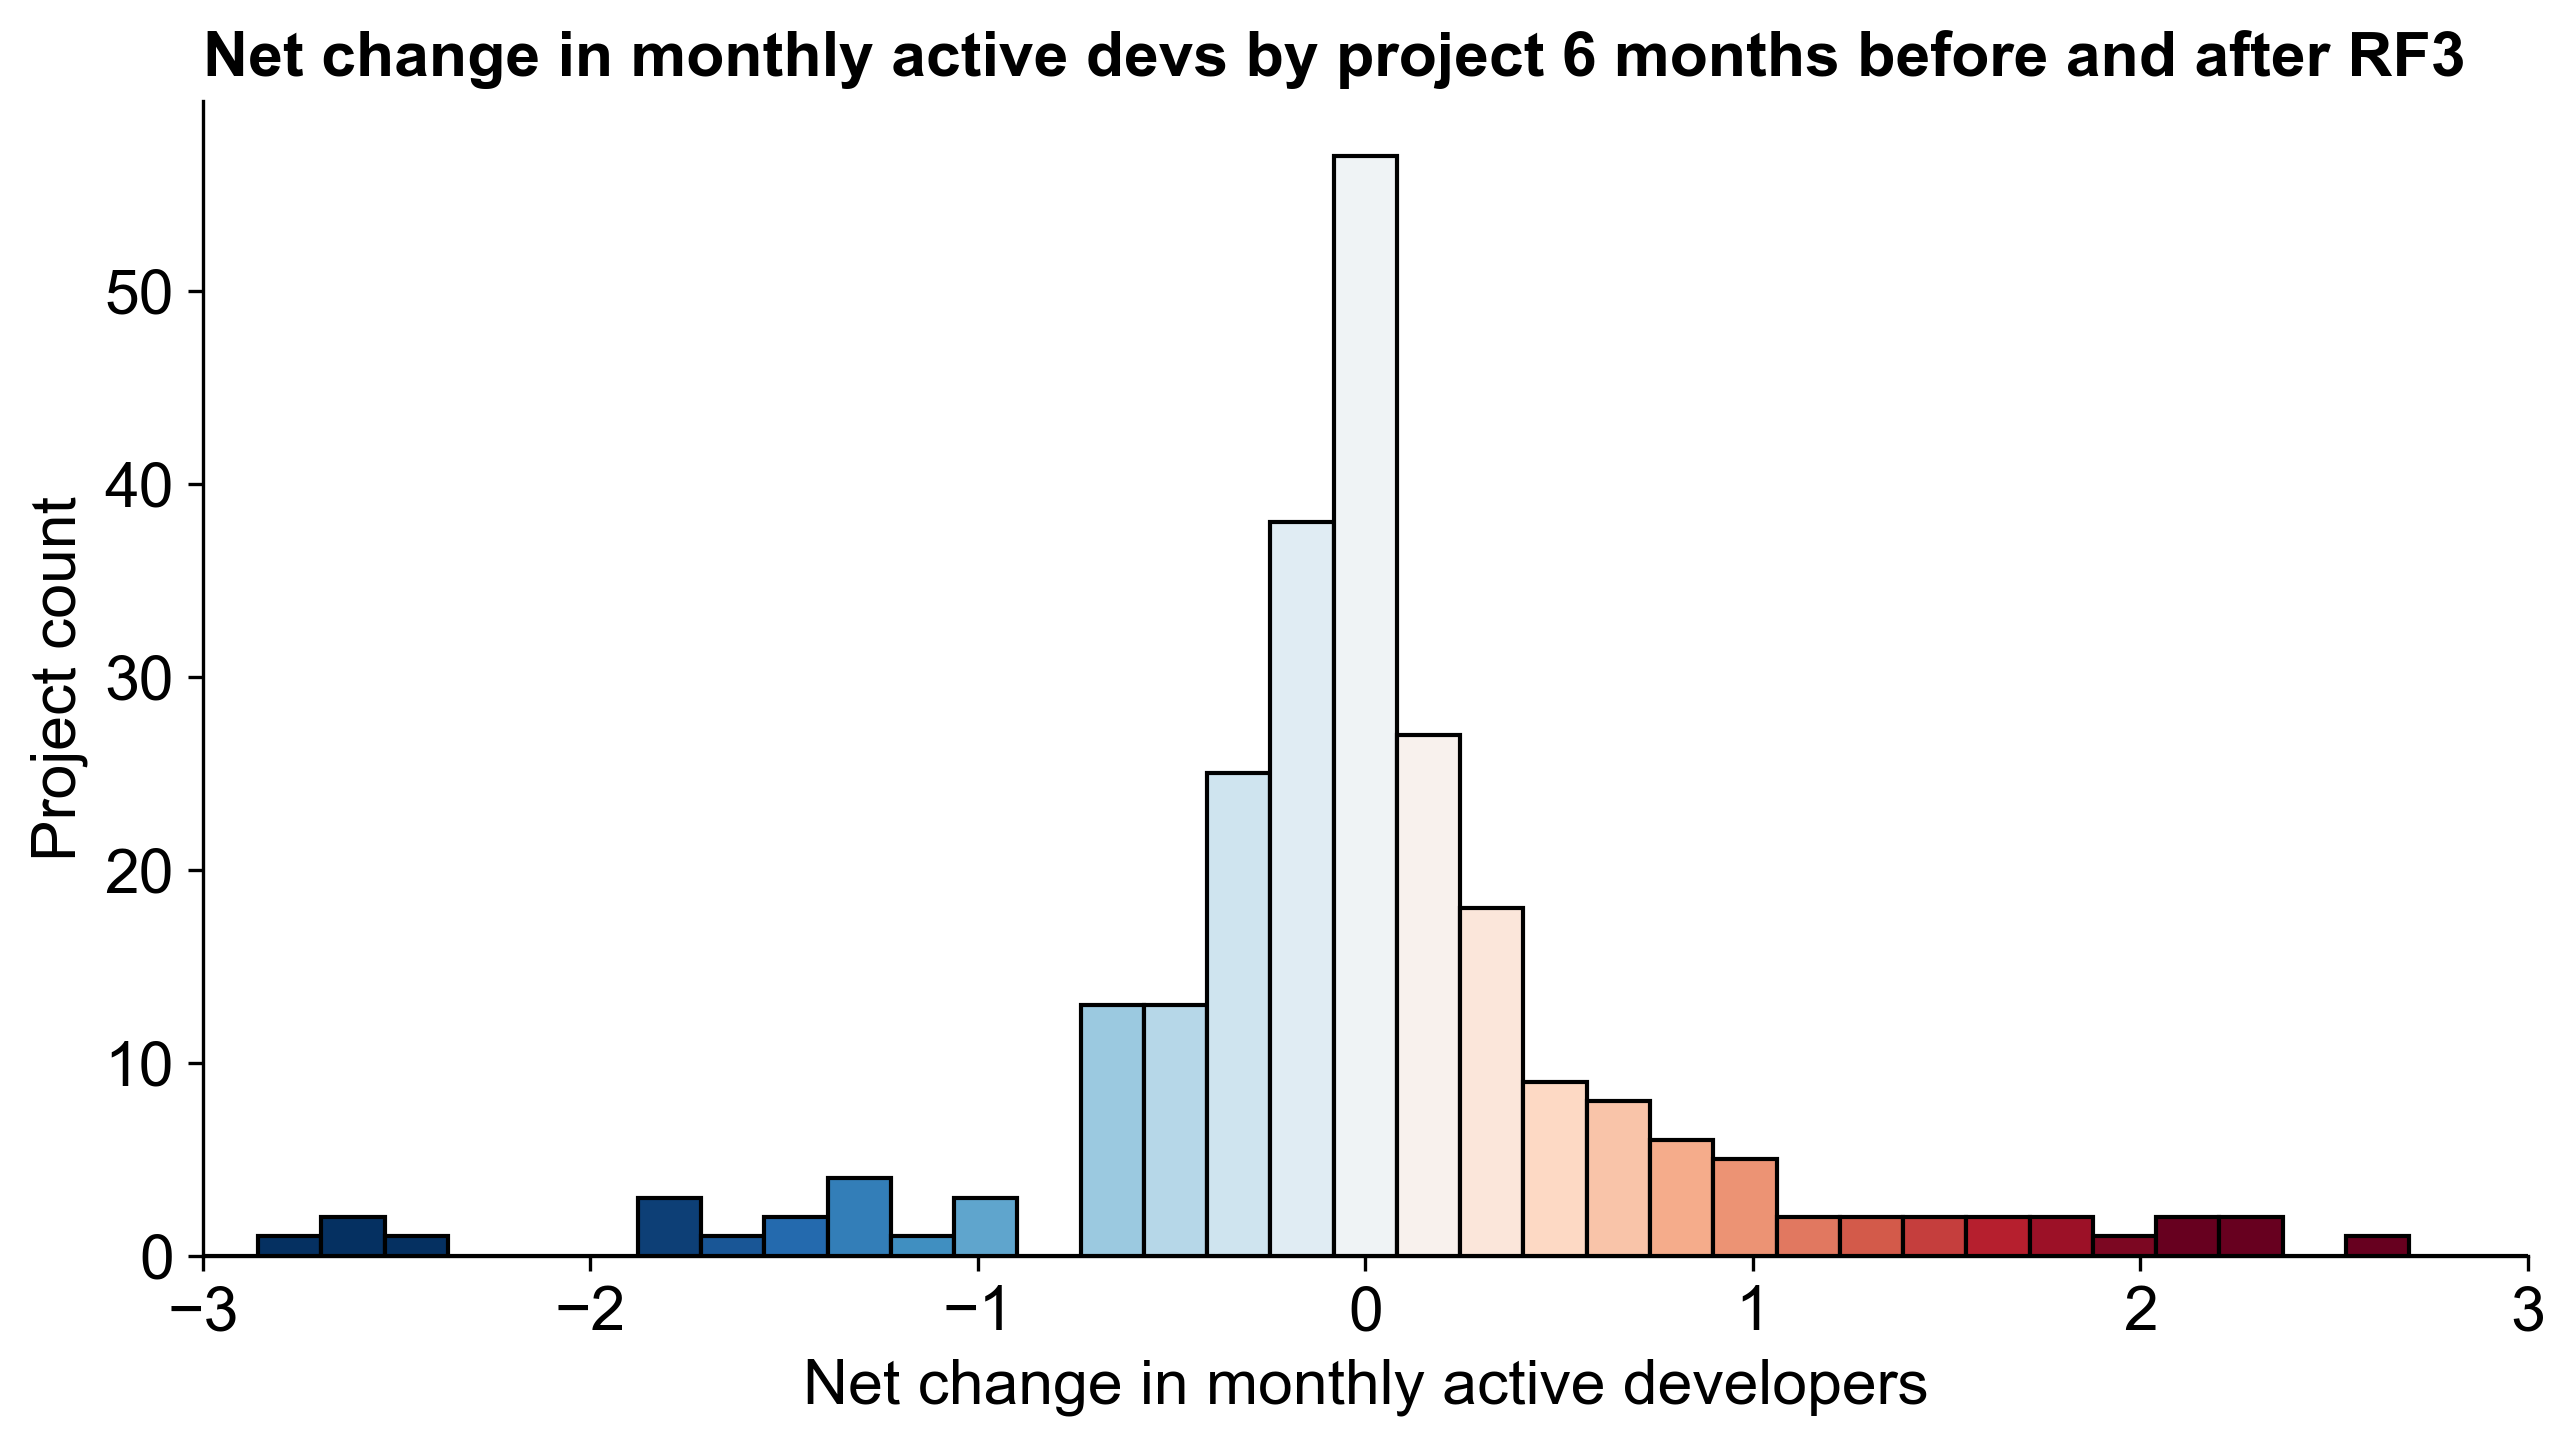

In [14]:
fig, ax = plt.subplots()

delta_values = delta_df.reindex(collections['op-rpgf3'])['delta'].dropna().reset_index()

cmap = cm.get_cmap('RdBu_r')
norm = Normalize(vmin=-2, vmax=2)

n, bins, patches = ax.hist(delta_values['delta'], bins=np.linspace(-4,4), edgecolor='black')

for bin_value, patch in zip(bins, patches):
    color = cmap(norm(bin_value))
    patch.set_facecolor(color)

ax.set_ylabel("Project count")
ax.set_xlabel("Net change in monthly active developers")
ax.set_title("Net change in monthly active devs by project 6 months before and after RF3", loc='left', weight='bold')
ax.set_xlim(-3, 3)

delta_sum = delta_values['delta'].sum()
print(delta_sum)

amount_per_dev_category
10-20K    60
20K+      51
<5K       47
5-10K     43
Name: count, dtype: int64


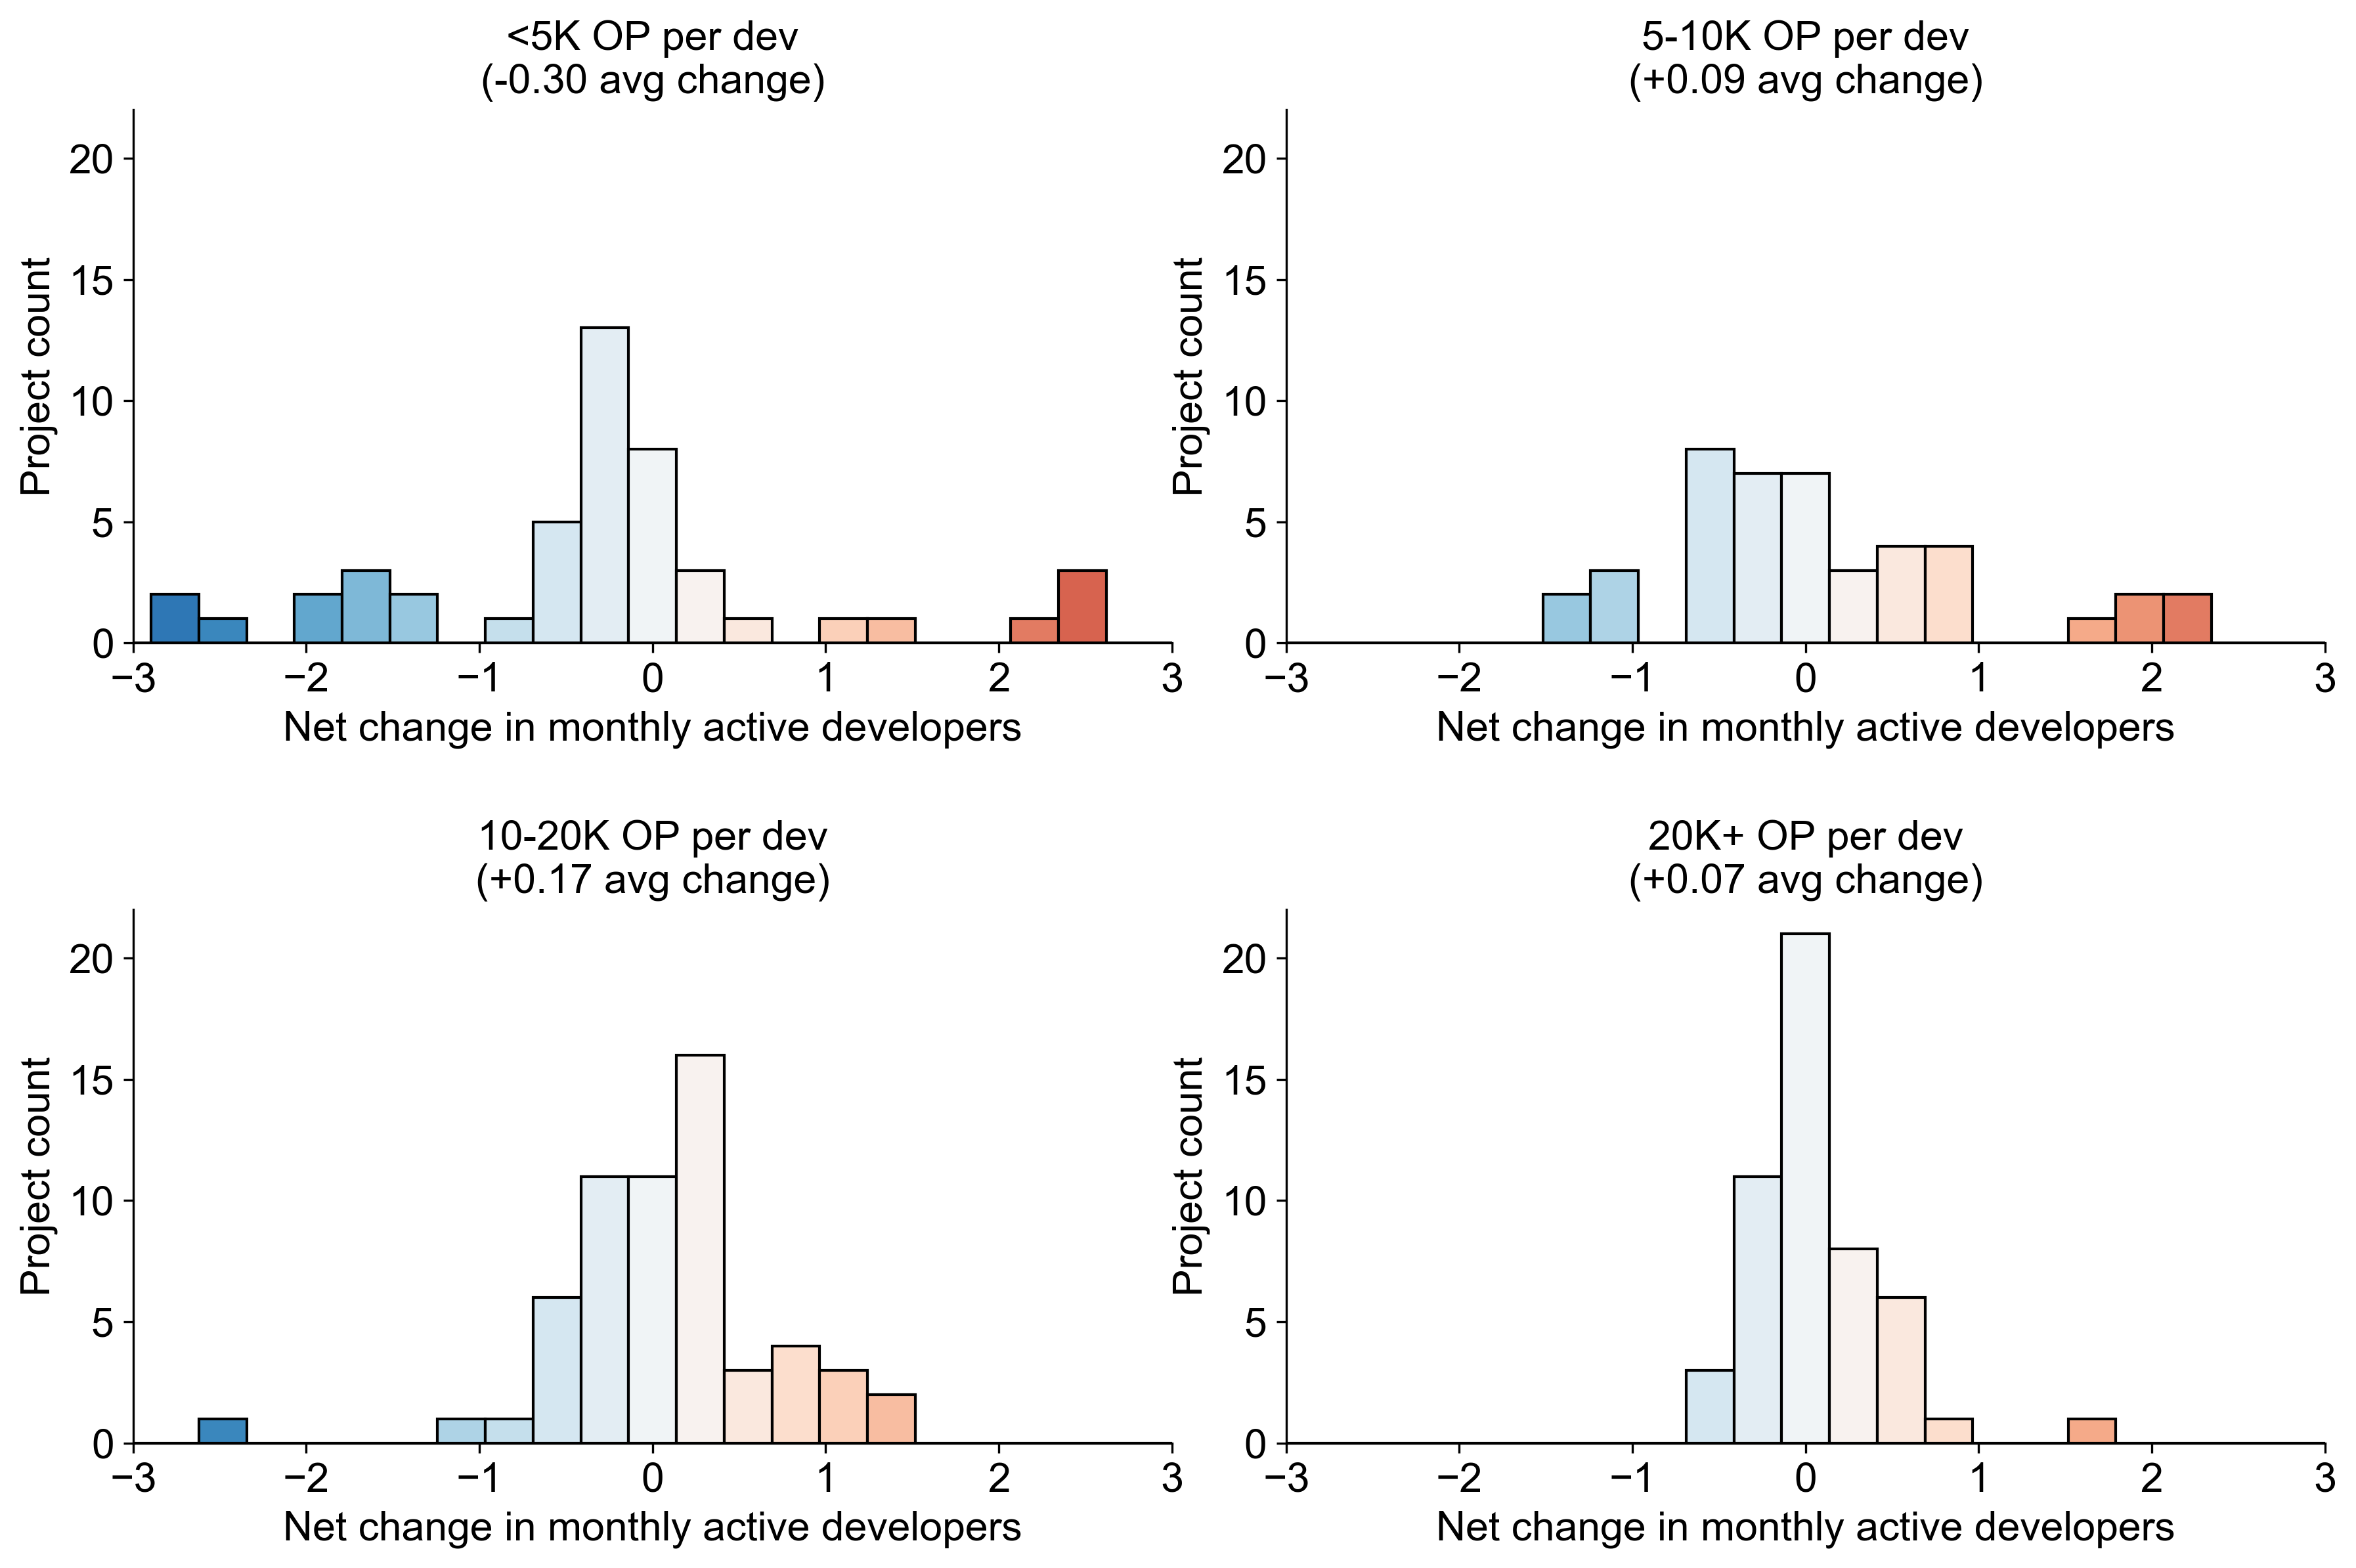

In [15]:
rf3_results = delta_df.set_index('project_name').join(RF3_RESULTS, how='right').dropna()
rf3_results = rf3_results[rf3_results[BEFORE] >= 1]

rf3_results['amount_per_dev'] = rf3_results['amount'] / rf3_results[BEFORE]
bins = [-float('inf'), 5000, 10000, 20000, float('inf')]
labels = ['<5K', '5-10K', '10-20K', '20K+']
rf3_results['amount_per_dev_category'] = pd.cut(rf3_results['amount_per_dev'], bins=bins, labels=labels)
print(rf3_results['amount_per_dev_category'].value_counts())

vals = rf3_results.groupby('amount_per_dev_category')['delta'].mean()
rf3_results['amount_per_dev_category_label'] = rf3_results['amount_per_dev_category'].apply(
    lambda x: f"{x} OP per dev\n({vals.get(x):+.2f} avg change)"
)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
cmap = cm.get_cmap('RdBu_r')
norm = Normalize(vmin=-4, vmax=4)

# Plot histograms for each category
for (i, lbl) in enumerate(labels):
    row = i // 2
    col = i % 2
    vals = rf3_results[rf3_results['amount_per_dev_category'] == lbl]['delta']
    n, hist_bins, patches = axes[row, col].hist(vals, bins=np.linspace(-4, 4, 30), edgecolor='black')
    
    for bin_value, patch in zip(hist_bins, patches):
        color = cmap(norm(bin_value))
        patch.set_facecolor(color)
    
    axes[row, col].set_title(f"{lbl} OP per dev\n({vals.mean():+.2f} avg change)")
    axes[row, col].set_xlim(-3, 3)
    axes[row, col].set_ylim(0,22)
    axes[row, col].set_xlabel('Net change in monthly active developers')
    axes[row, col].set_ylabel('Project count')
    

fig.tight_layout()
fig.subplots_adjust(hspace=.5, wspace=.11)

## Changes in onchain activity

What has been the change in onchain activity 6 months before and after Retro Funding 3?
1. Among RF4 applicants
2. By cohort
3. Compared to baseline

In [16]:
df_txns = TRANSACTIONS_BY_CHAIN.copy()
df_txns['bucket_day'] = pd.to_datetime(df_txns['bucket_day'].apply(lambda x: x.split()[0]))
superchain_networks = ['OPTIMISM', 'BASE', 'ZORA', 'MODE']
df_txns['network_label'] = df_txns['network'].apply(lambda x: 'SUPERCHAIN' if x in superchain_networks else x)
df_txns['project_name'] = df_txns['project_id'].map(projects)
df_txns['is_rf4'] = df_txns['project_id'].isin(collections['op-retrofunding-4'])
df_txns['cohort'] = df_txns['project_id'].map(project_cohort_mapping)
df_txns['cohort'].fillna('Unmapped', inplace=True)
df_txns['superchain'] = df_txns['network'].isin(superchain_networks)
df_txns['6_month_interval']= df_txns['bucket_day'].apply(assign_6_month_interval)
df_txns.tail()

bucket_day                                    project_id network  \
259020 2024-05-13  8RsppqhF6-tHDEnVATmtwf_fUMeOg6EsIn92GIR7NkI=    ZORA   
259021 2024-05-21  8RsppqhF6-tHDEnVATmtwf_fUMeOg6EsIn92GIR7NkI=    ZORA   
259022 2024-03-25  8RsppqhF6-tHDEnVATmtwf_fUMeOg6EsIn92GIR7NkI=    ZORA   
259023 2024-05-06  bCXvtpzVfkfzitw2N3LoqtlBfRmnpPb2CMVXZzgoK54=    ZORA   
259024 2024-01-23  jhbwVCWNelyiMntcZPWGmOgRl7buxEMIdgPhfvT0LPk=    ZORA   

        num_txns network_label project_name  is_rf4                 cohort  \
259020      2186    SUPERCHAIN    rubyscore    True  First-time RF project   
259021      2454    SUPERCHAIN    rubyscore    True  First-time RF project   
259022        74    SUPERCHAIN    rubyscore    True  First-time RF project   
259023        26    SUPERCHAIN          NaN   False               Unmapped   
259024        14    SUPERCHAIN   pods-media    True  First-time RF project   

        superchain    6_month_interval  
259020        True  2023-12 to 2024-05  
259021        True  2023-12 to 2024-05  
259022        True  2023-12 to 2024-05  
259023        True  2023-12 to 2024-05  
259024        True  2023-12 to 2024-05

Text(0.0, 1.0, 'Daily transactions for projects in RF4\n')

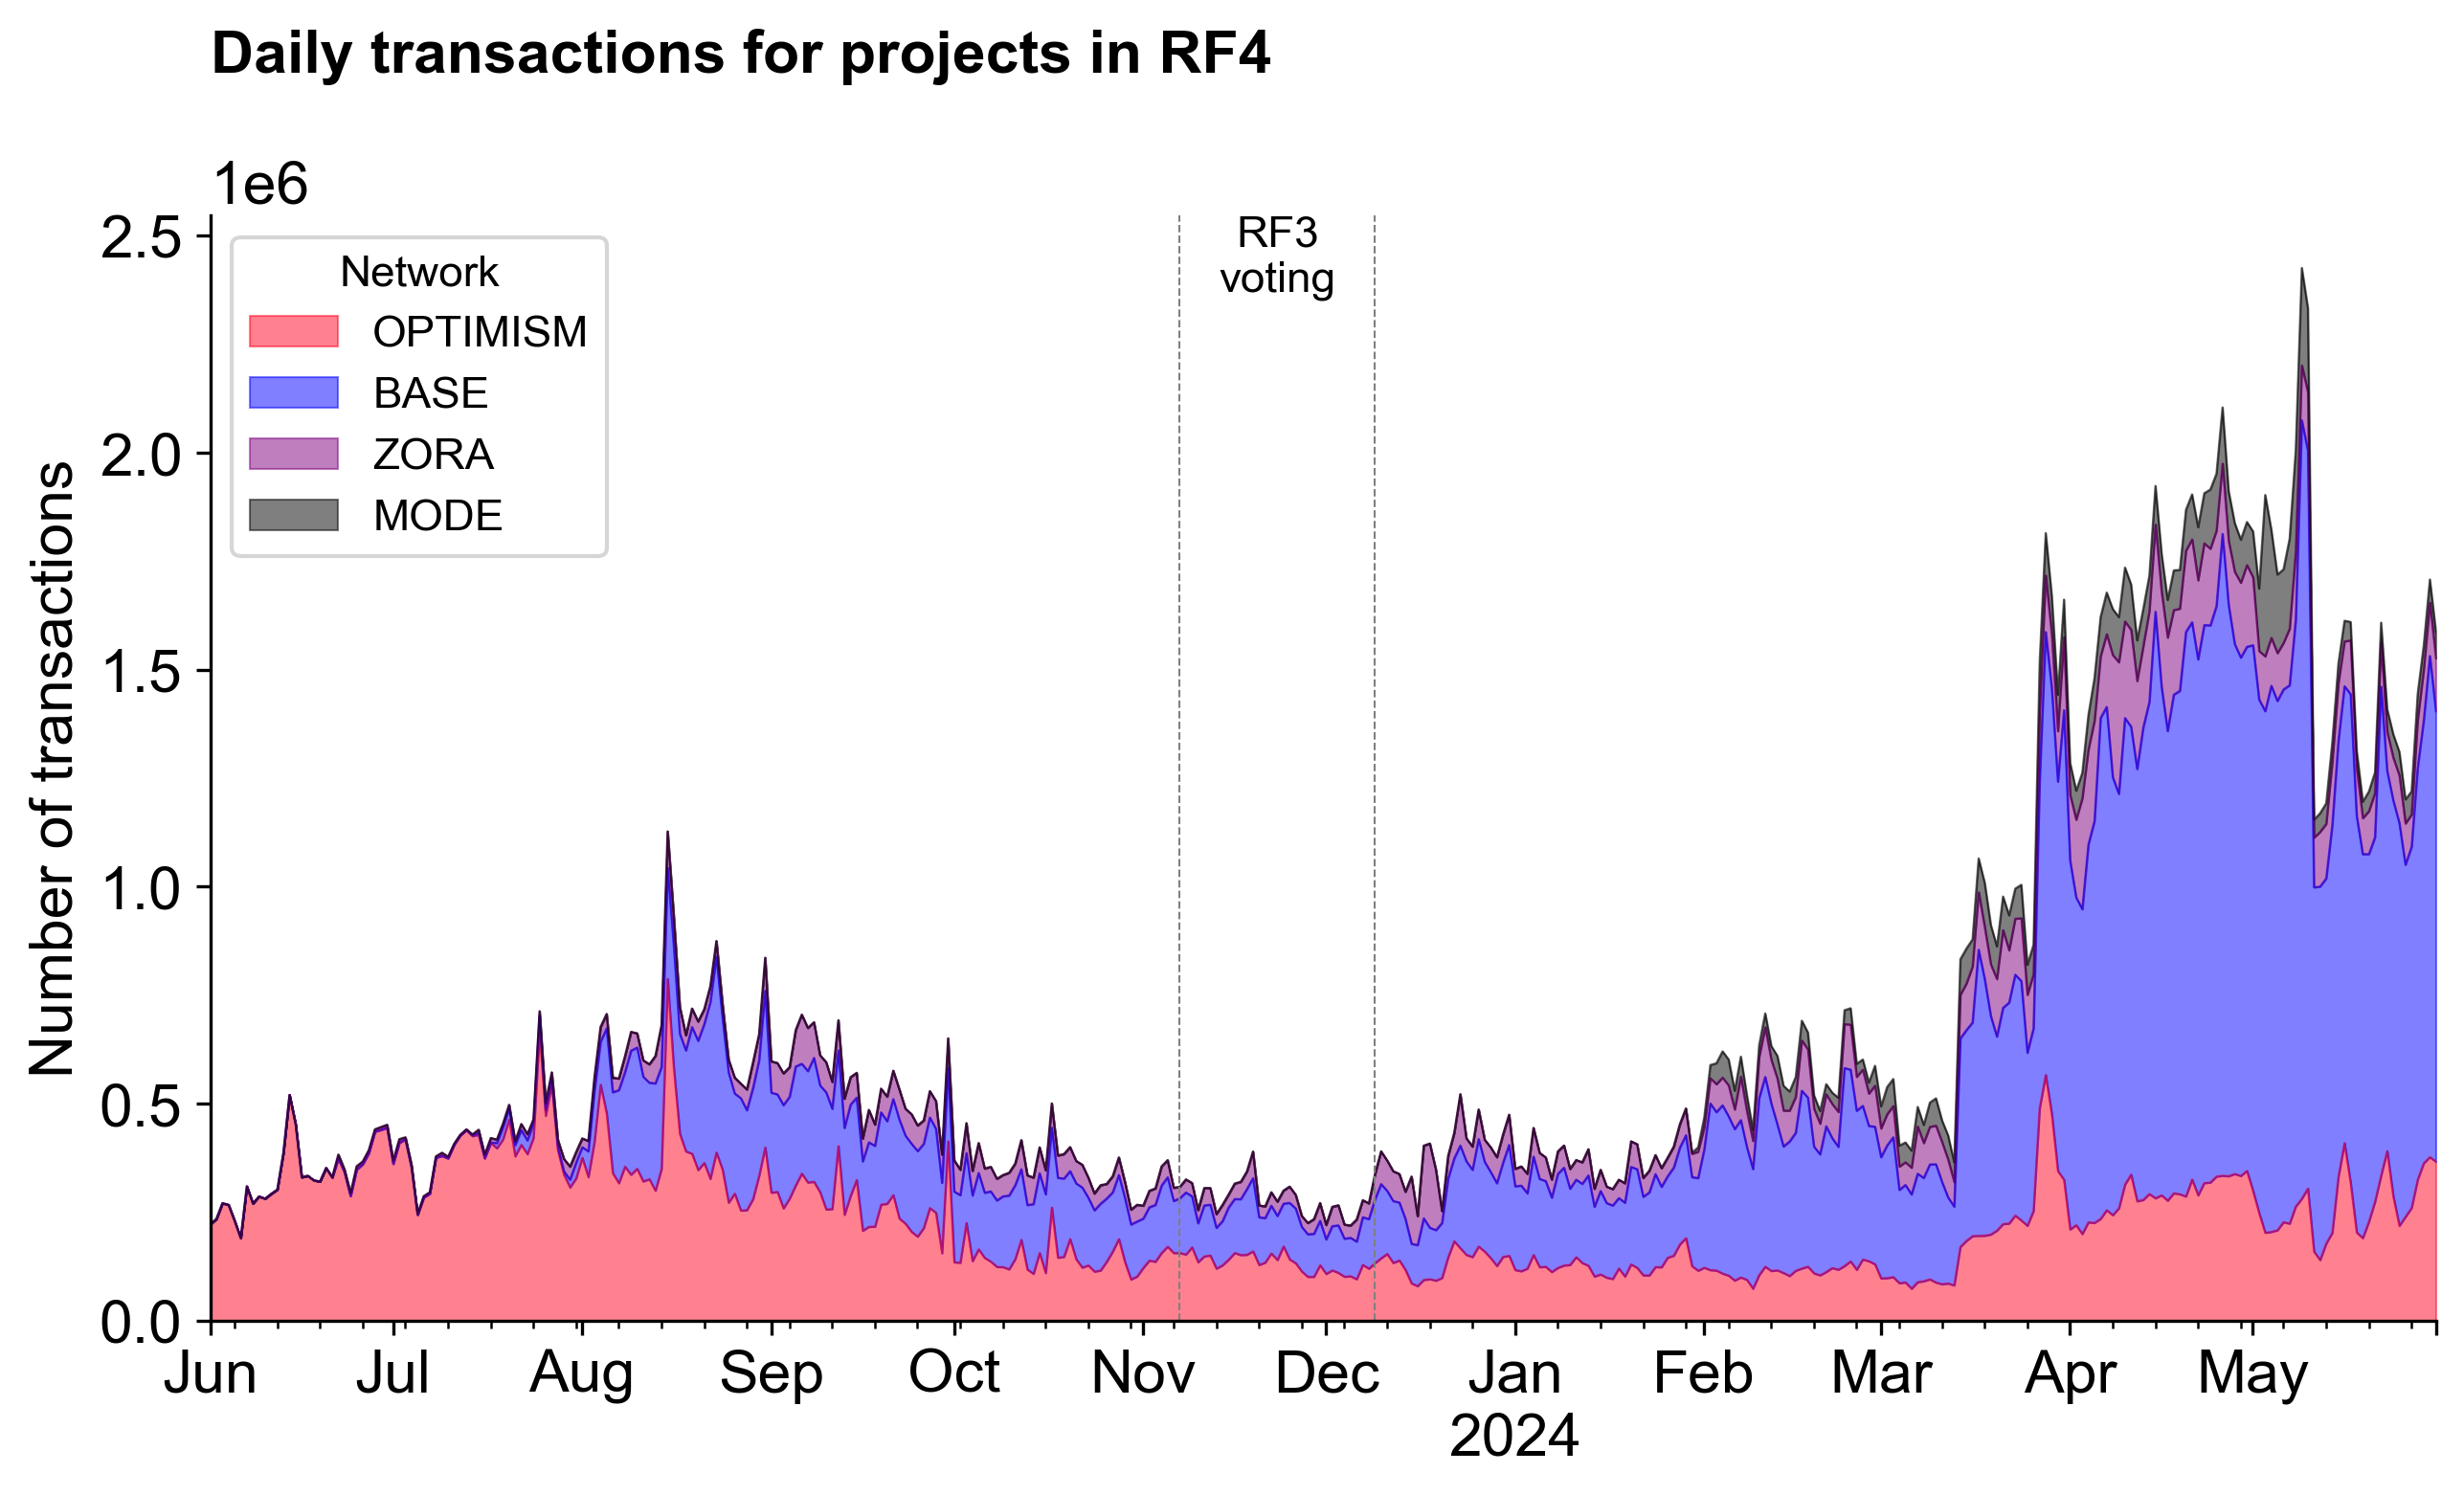

In [17]:
fig, ax = plt.subplots()

txns_pvt = (
    df_txns[(df_txns['is_rf4']) & (df_txns['network'].isin(superchain_networks))]
    .pivot_table(
        index='bucket_day',
        columns='network',
        values='num_txns',
        aggfunc='sum',
        fill_value=0
    )
    [superchain_networks]
)
txns_pvt.plot(
    kind='area', 
    color=[COLOR1, 'blue', 'purple', 'black'],
    alpha=.5,
    lw=.5,
    ax=ax
)

ax.axvline(pd.to_datetime('2023-11-07'), color='gray', ls='--', lw=.5)
ax.axvline(pd.to_datetime('2023-12-09'), color='gray', ls='--', lw=.5)
ax.text(x=pd.to_datetime('2023-11-23'), y=ax.get_ylim()[-1], s='RF3\nvoting', va='top', ha='center', size=SUB_SIZE)

ax.set_ylim(0,)
ax.set_ylabel("Number of transactions")
ax.set_xlabel("")
ax.legend(title="Network")
ax.set_title("Daily transactions for projects in RF4\n", loc='left', weight='bold')

Text(0.0, 1.0, 'Daily transactions for projects in RF4 by cohort\n')

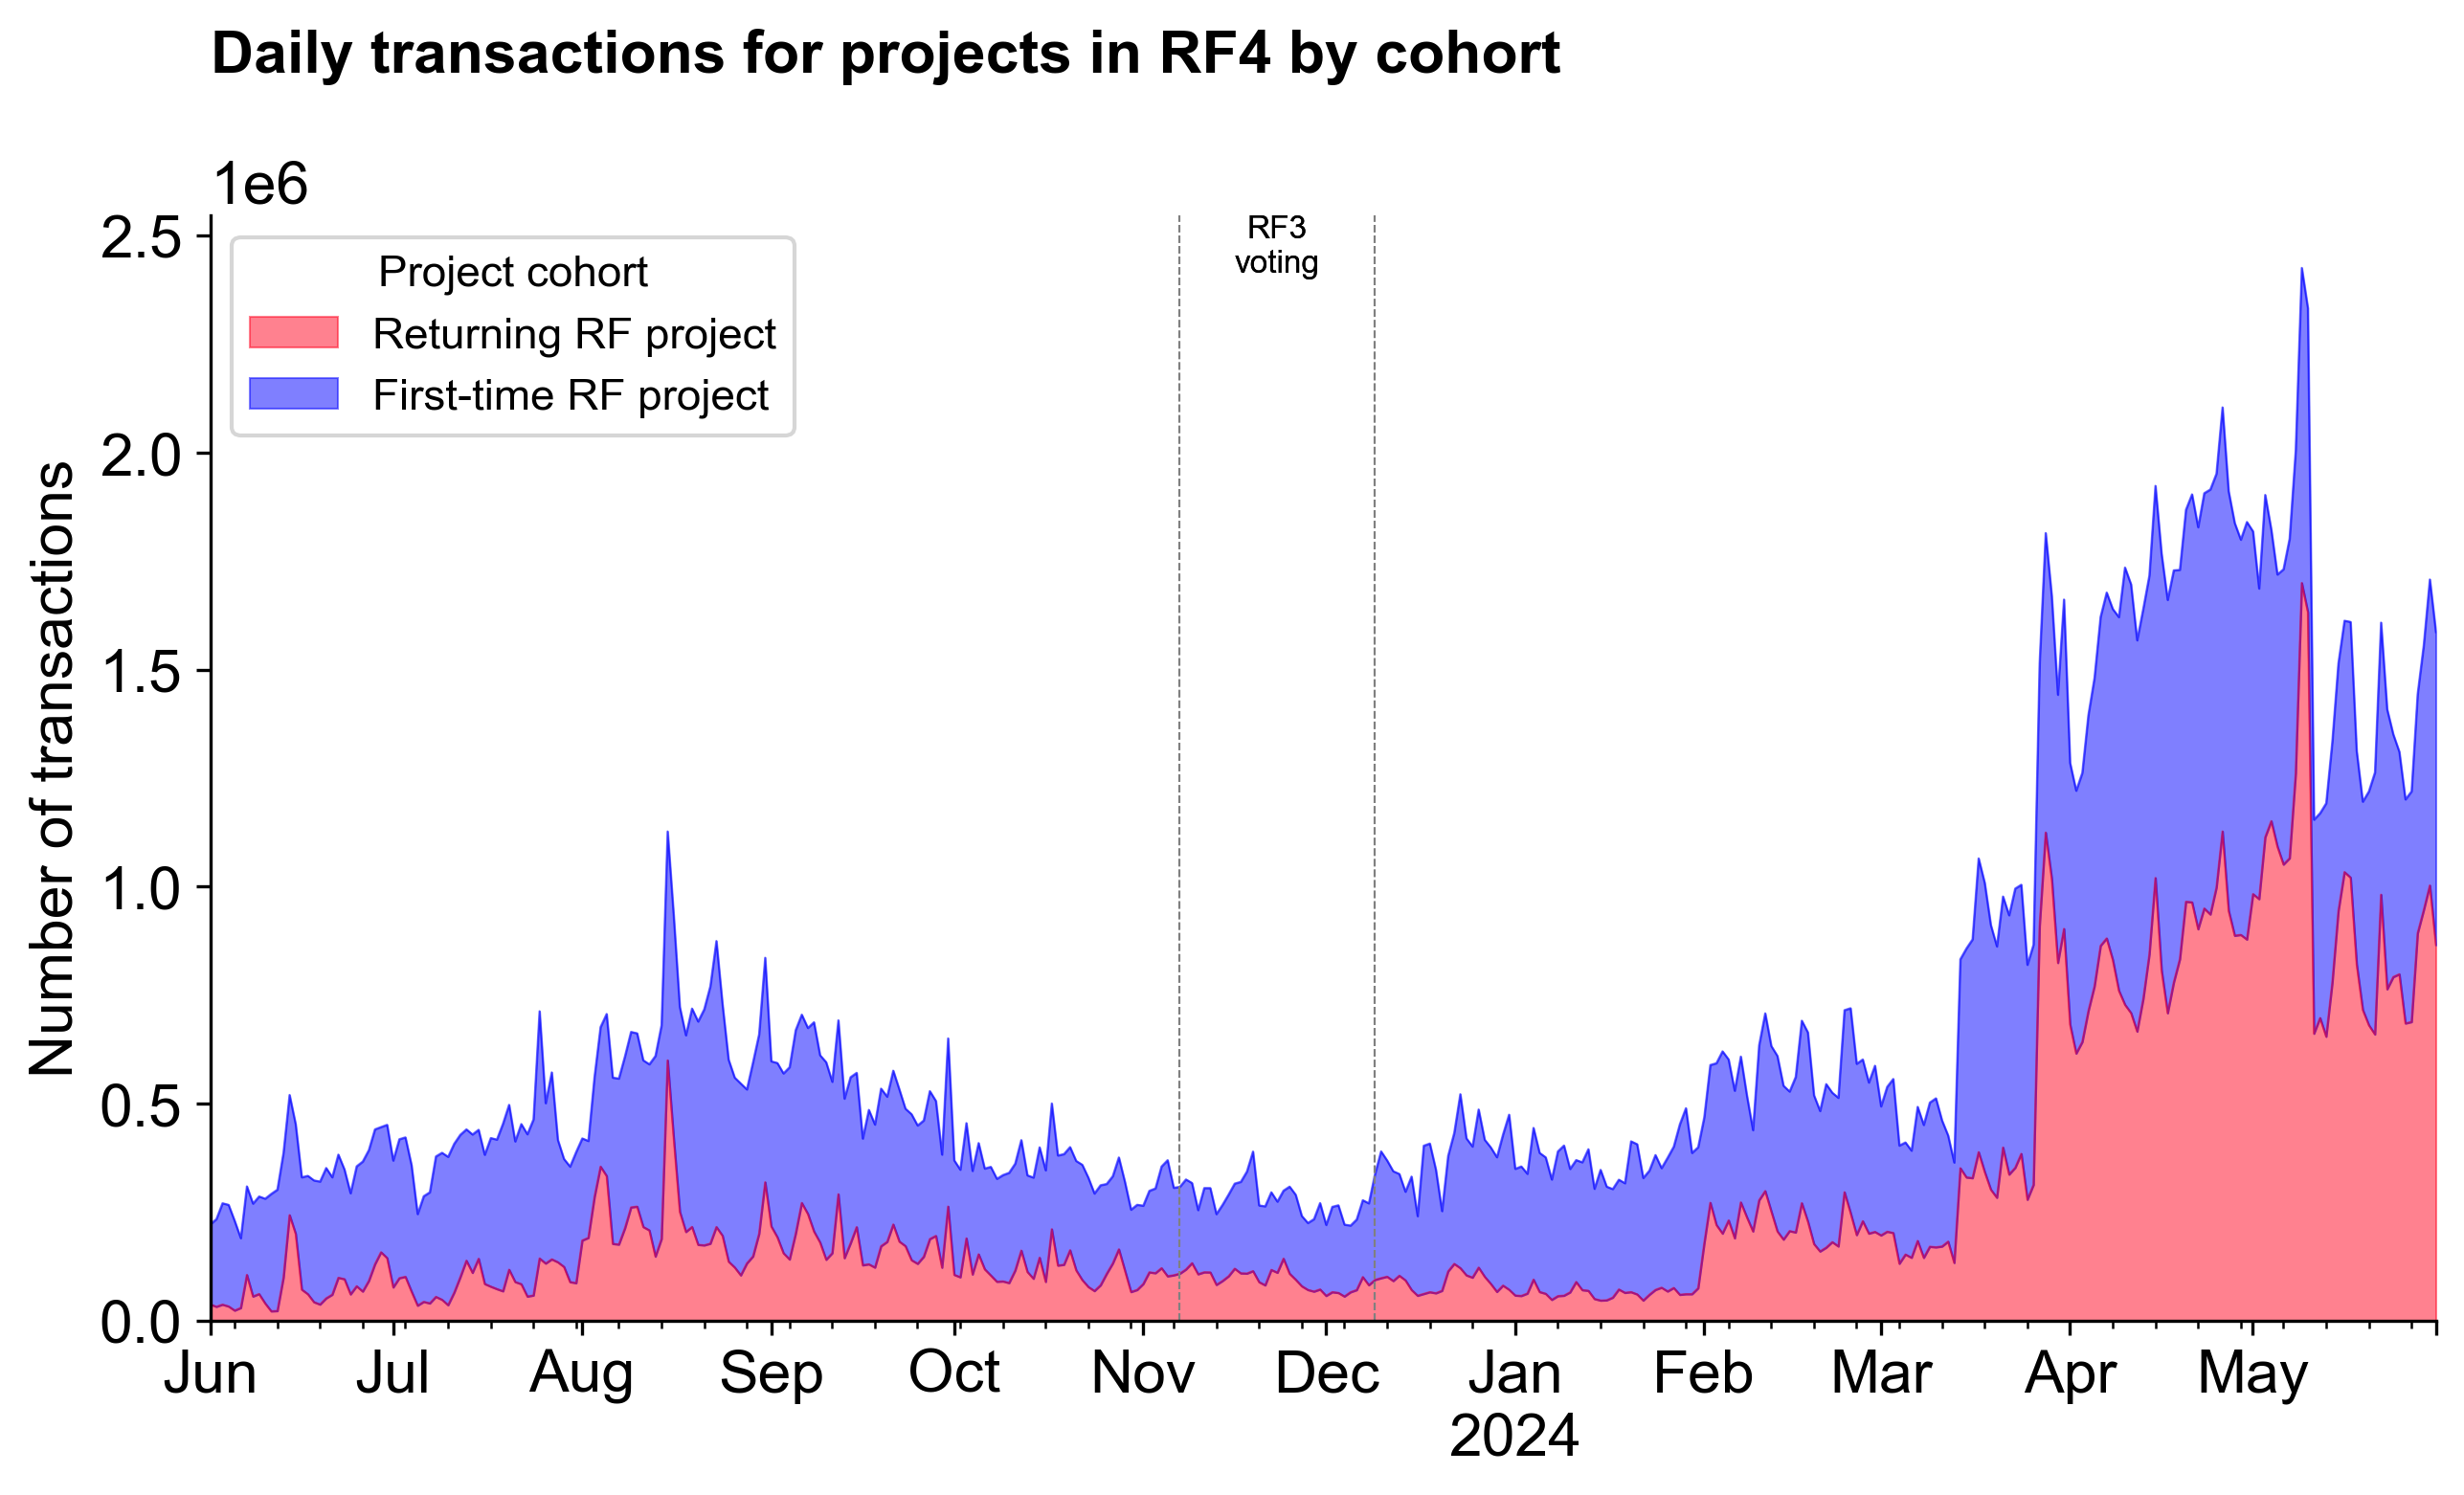

In [18]:
fig, ax = plt.subplots()

txns_pvt = (
    df_txns[(df_txns['is_rf4']) & (df_txns['network'].isin(superchain_networks))]
    .pivot_table(
        index='bucket_day',
        columns='cohort',
        values='num_txns',
        aggfunc='sum',
        fill_value=0
    )
    [['Returning RF project', 'First-time RF project']]
)
txns_pvt.plot(
    kind='area', 
    color=[COLOR1, 'blue'],
    alpha=.5,
    lw=.5,
    ax=ax
)

ax.axvline(pd.to_datetime('2023-11-07'), color='gray', ls='--', lw=.5)
ax.axvline(pd.to_datetime('2023-12-09'), color='gray', ls='--', lw=.5)
ax.text(x=pd.to_datetime('2023-11-23'), y=ax.get_ylim()[-1], s='RF3\nvoting', va='top', ha='center')

ax.axvline(pd.to_datetime('2023-11-07'), color='gray', ls='--', lw=.5)
ax.axvline(pd.to_datetime('2023-12-09'), color='gray', ls='--', lw=.5)
ax.text(x=pd.to_datetime('2023-11-23'), y=ax.get_ylim()[-1], s='RF3\nvoting', va='top', ha='center')

ax.set_ylim(0,)
ax.set_ylabel("Number of transactions")
ax.set_xlabel("")
ax.legend(title="Project cohort")
ax.set_title("Daily transactions for projects in RF4 by cohort\n", loc='left', weight='bold')

Text(0.0, 1.0, 'Daily transactions for projects in RF4 by cohort, including past recipients\n')

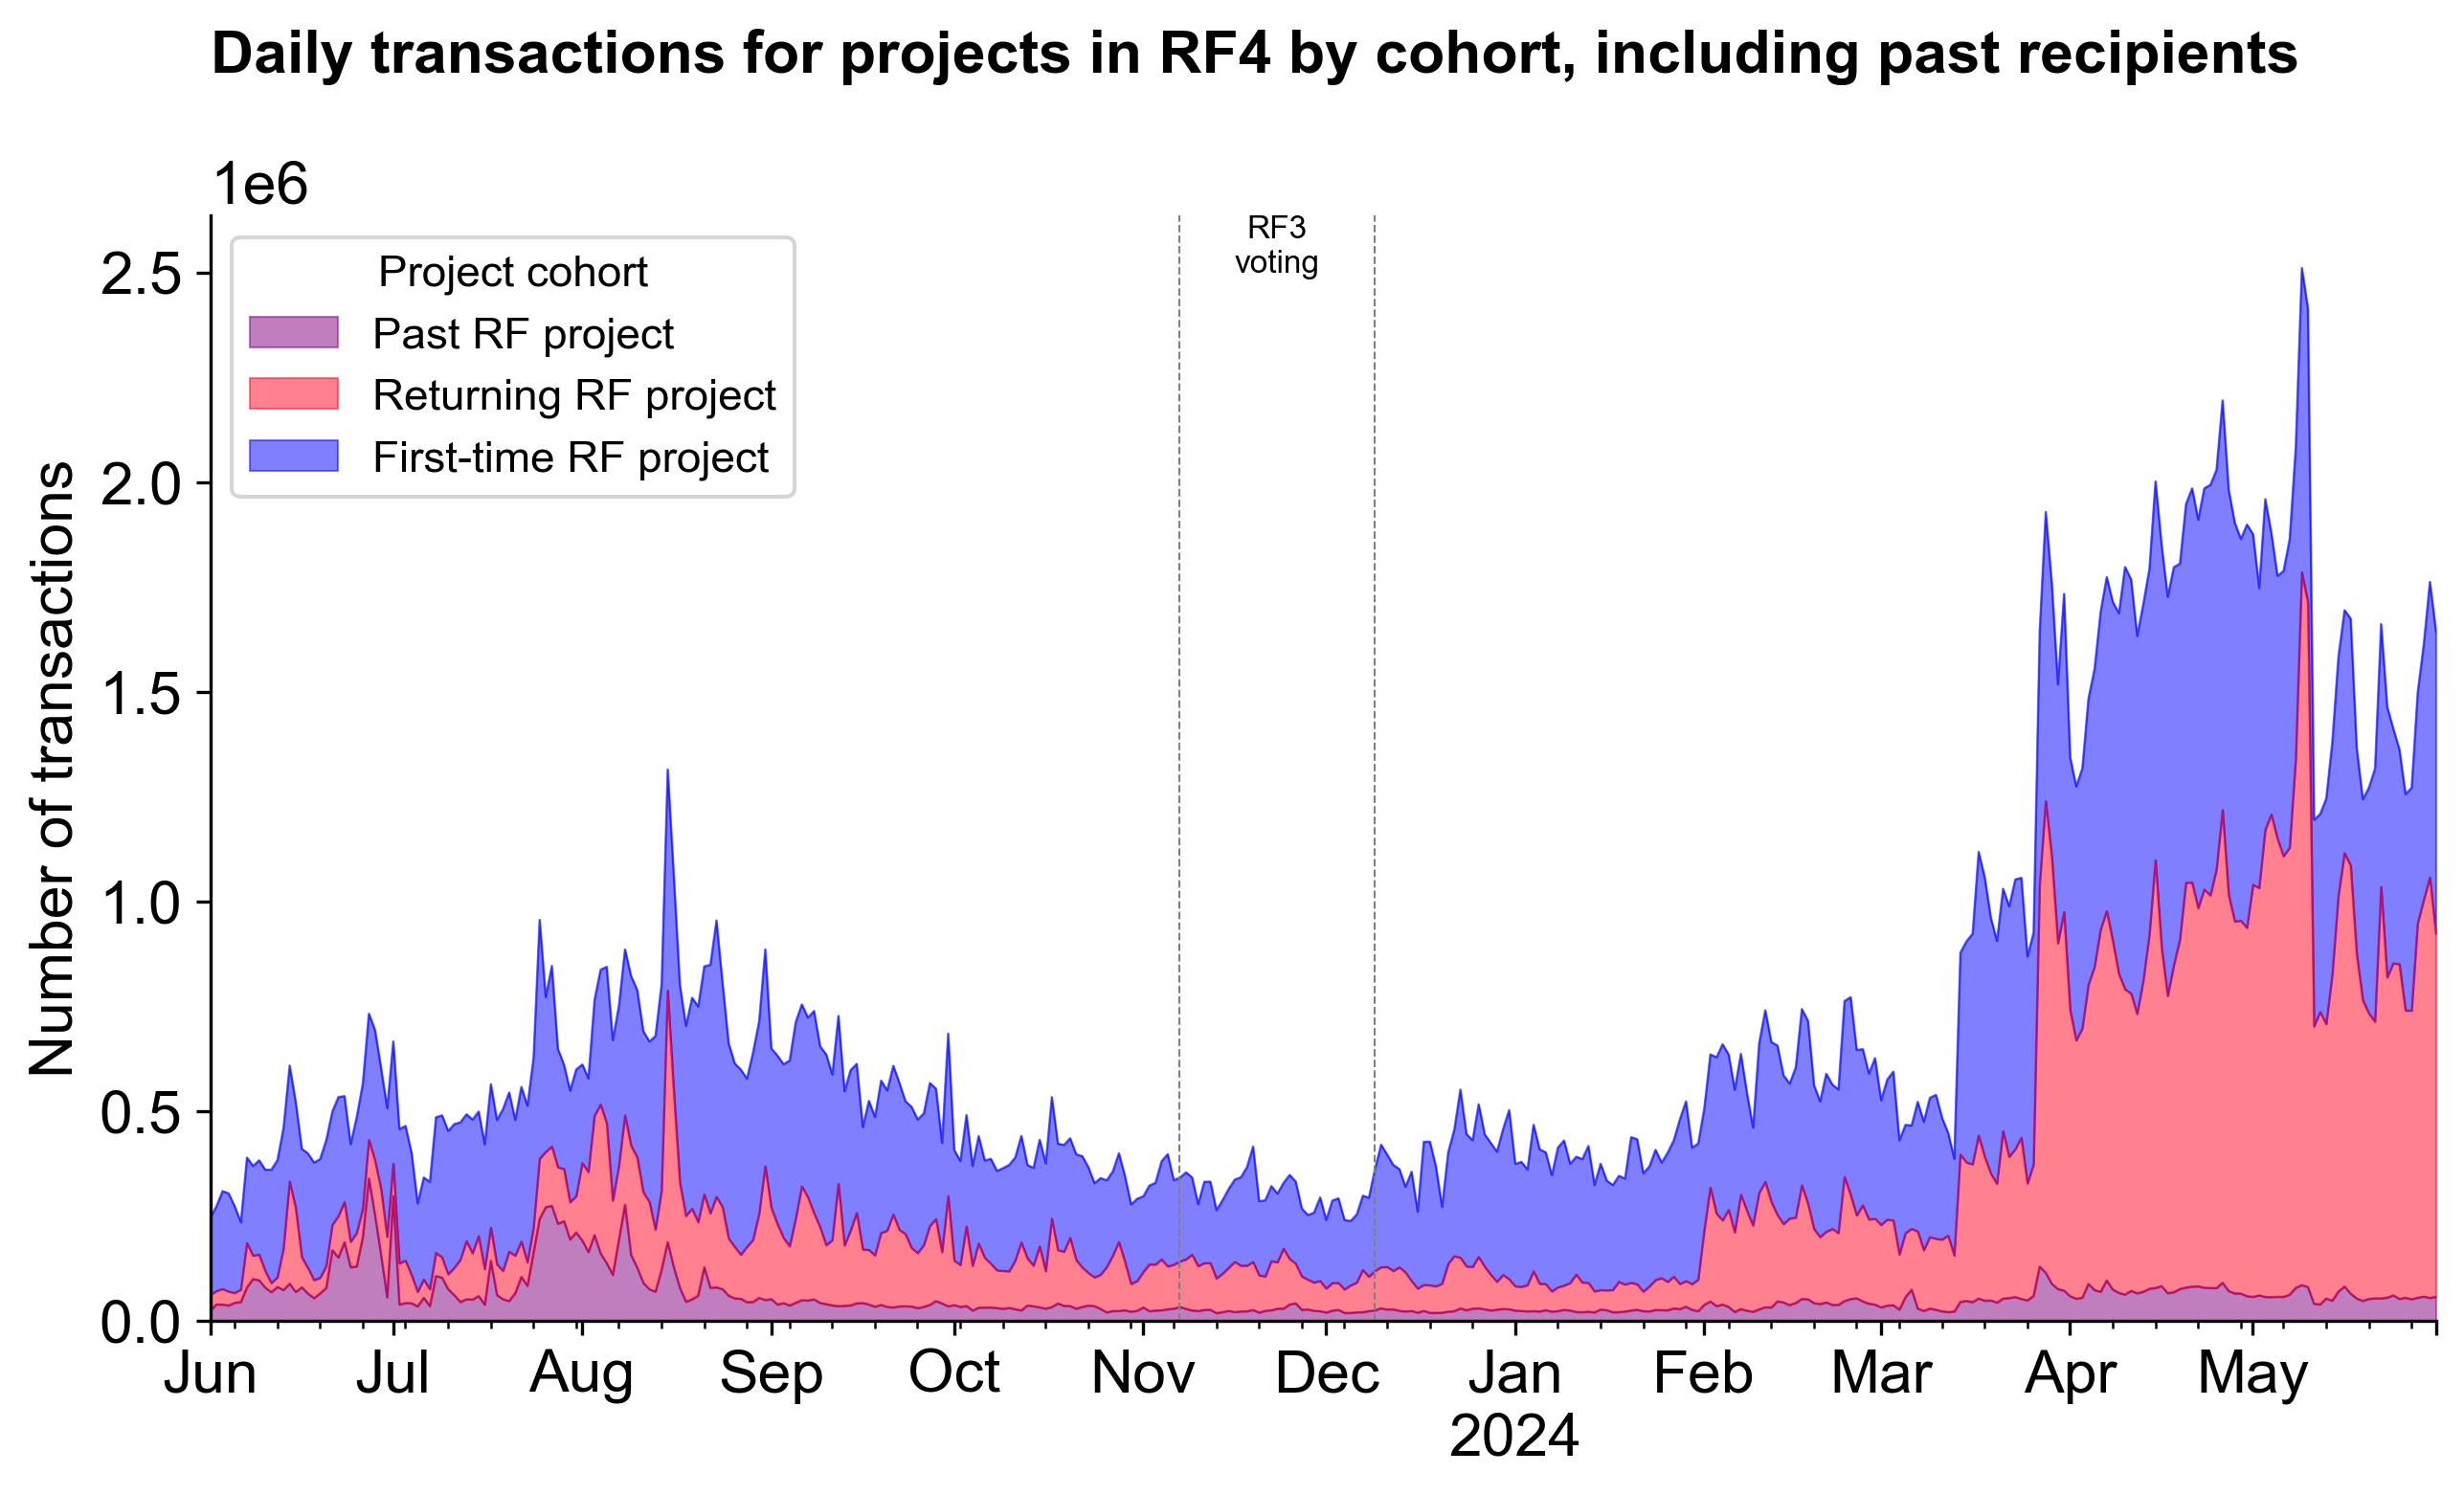

In [19]:
fig, ax = plt.subplots()

txns_pvt = (
    df_txns[df_txns['network'].isin(superchain_networks)]
    .pivot_table(
        index='bucket_day',
        columns='cohort',
        values='num_txns',
        aggfunc='sum',
        fill_value=0
    )
    [['Past RF project', 'Returning RF project', 'First-time RF project']]
)
txns_pvt.plot(
    kind='area', 
    color=['purple', COLOR1, 'blue'],
    alpha=.5,
    lw=.5,
    ax=ax
)

ax.axvline(pd.to_datetime('2023-11-07'), color='gray', ls='--', lw=.5)
ax.axvline(pd.to_datetime('2023-12-09'), color='gray', ls='--', lw=.5)
ax.text(x=pd.to_datetime('2023-11-23'), y=ax.get_ylim()[-1], s='RF3\nvoting', va='top', ha='center')

ax.set_ylim(0,)
ax.set_ylabel("Number of transactions")
ax.set_xlabel("")
ax.legend(title="Project cohort")
ax.set_title("Daily transactions for projects in RF4 by cohort, including past recipients\n", loc='left', weight='bold')

Text(0.0, 1.0, 'Daily transactions for projects in RF4 vs rest of Superchain\n')

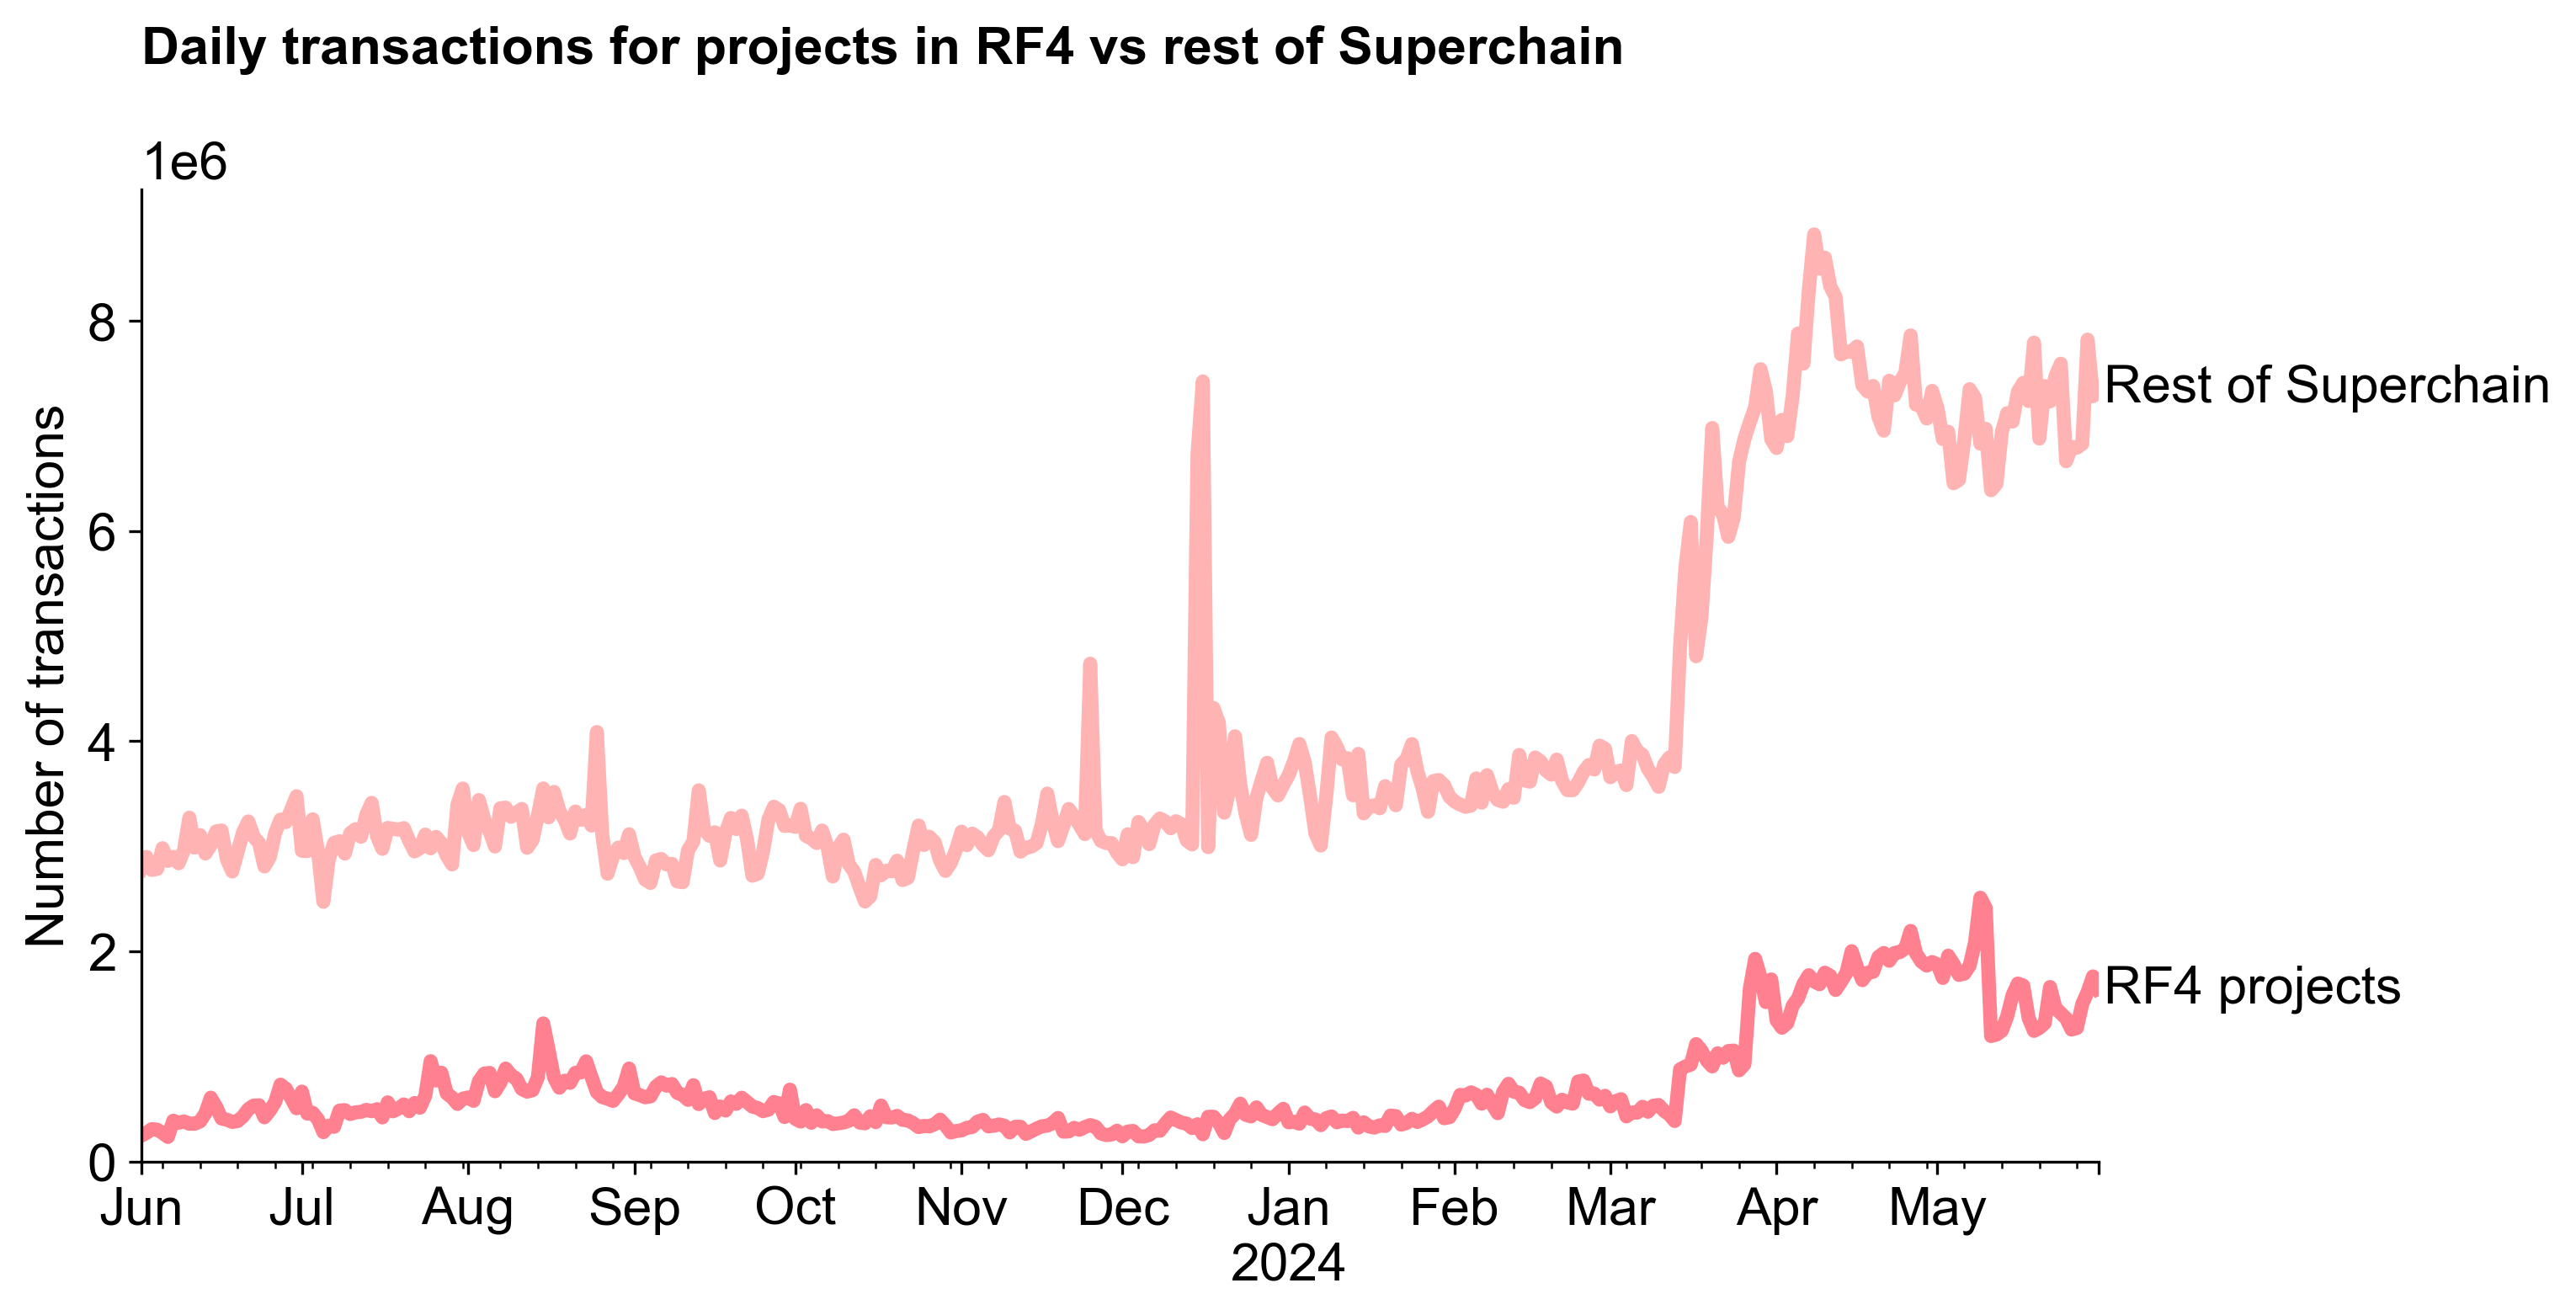

In [20]:
fig, ax = plt.subplots()

rf4_txns = (
    df_txns[(df_txns['network'].isin(superchain_networks)) & df_txns['project_id'].isin(rf_projects)==True]
    .groupby('bucket_day')['num_txns'].sum()
)
rf4_txns.plot(kind='line', color=COLOR1, alpha=.5, lw=4, ax=ax)

other_txns = (
    df_txns[(df_txns['network'].isin(superchain_networks)) & df_txns['project_id'].isin(rf_projects)==False]
    .groupby('bucket_day')['num_txns'].sum()
)
other_txns.plot(kind='line', color=COLOR2, alpha=.5, lw=4, ax=ax)

xmax = ax.get_xlim()[-1]
ax.text(x=xmax+1, y=rf4_txns.iloc[-1], s="RF4 projects", va='center', size=FONT_SIZE)
ax.text(x=xmax+1, y=other_txns.iloc[-1], s="Rest of Superchain", va='center', size=FONT_SIZE)

ax.set_ylim(0,)
ax.set_ylabel("Number of transactions")
ax.set_xlabel("")
ax.set_title("Daily transactions for projects in RF4 vs rest of Superchain\n", loc='left', weight='bold')

Text(0.0, 1.0, 'Ratio of transactions from projects in RF4 to rest of Superchain\n')

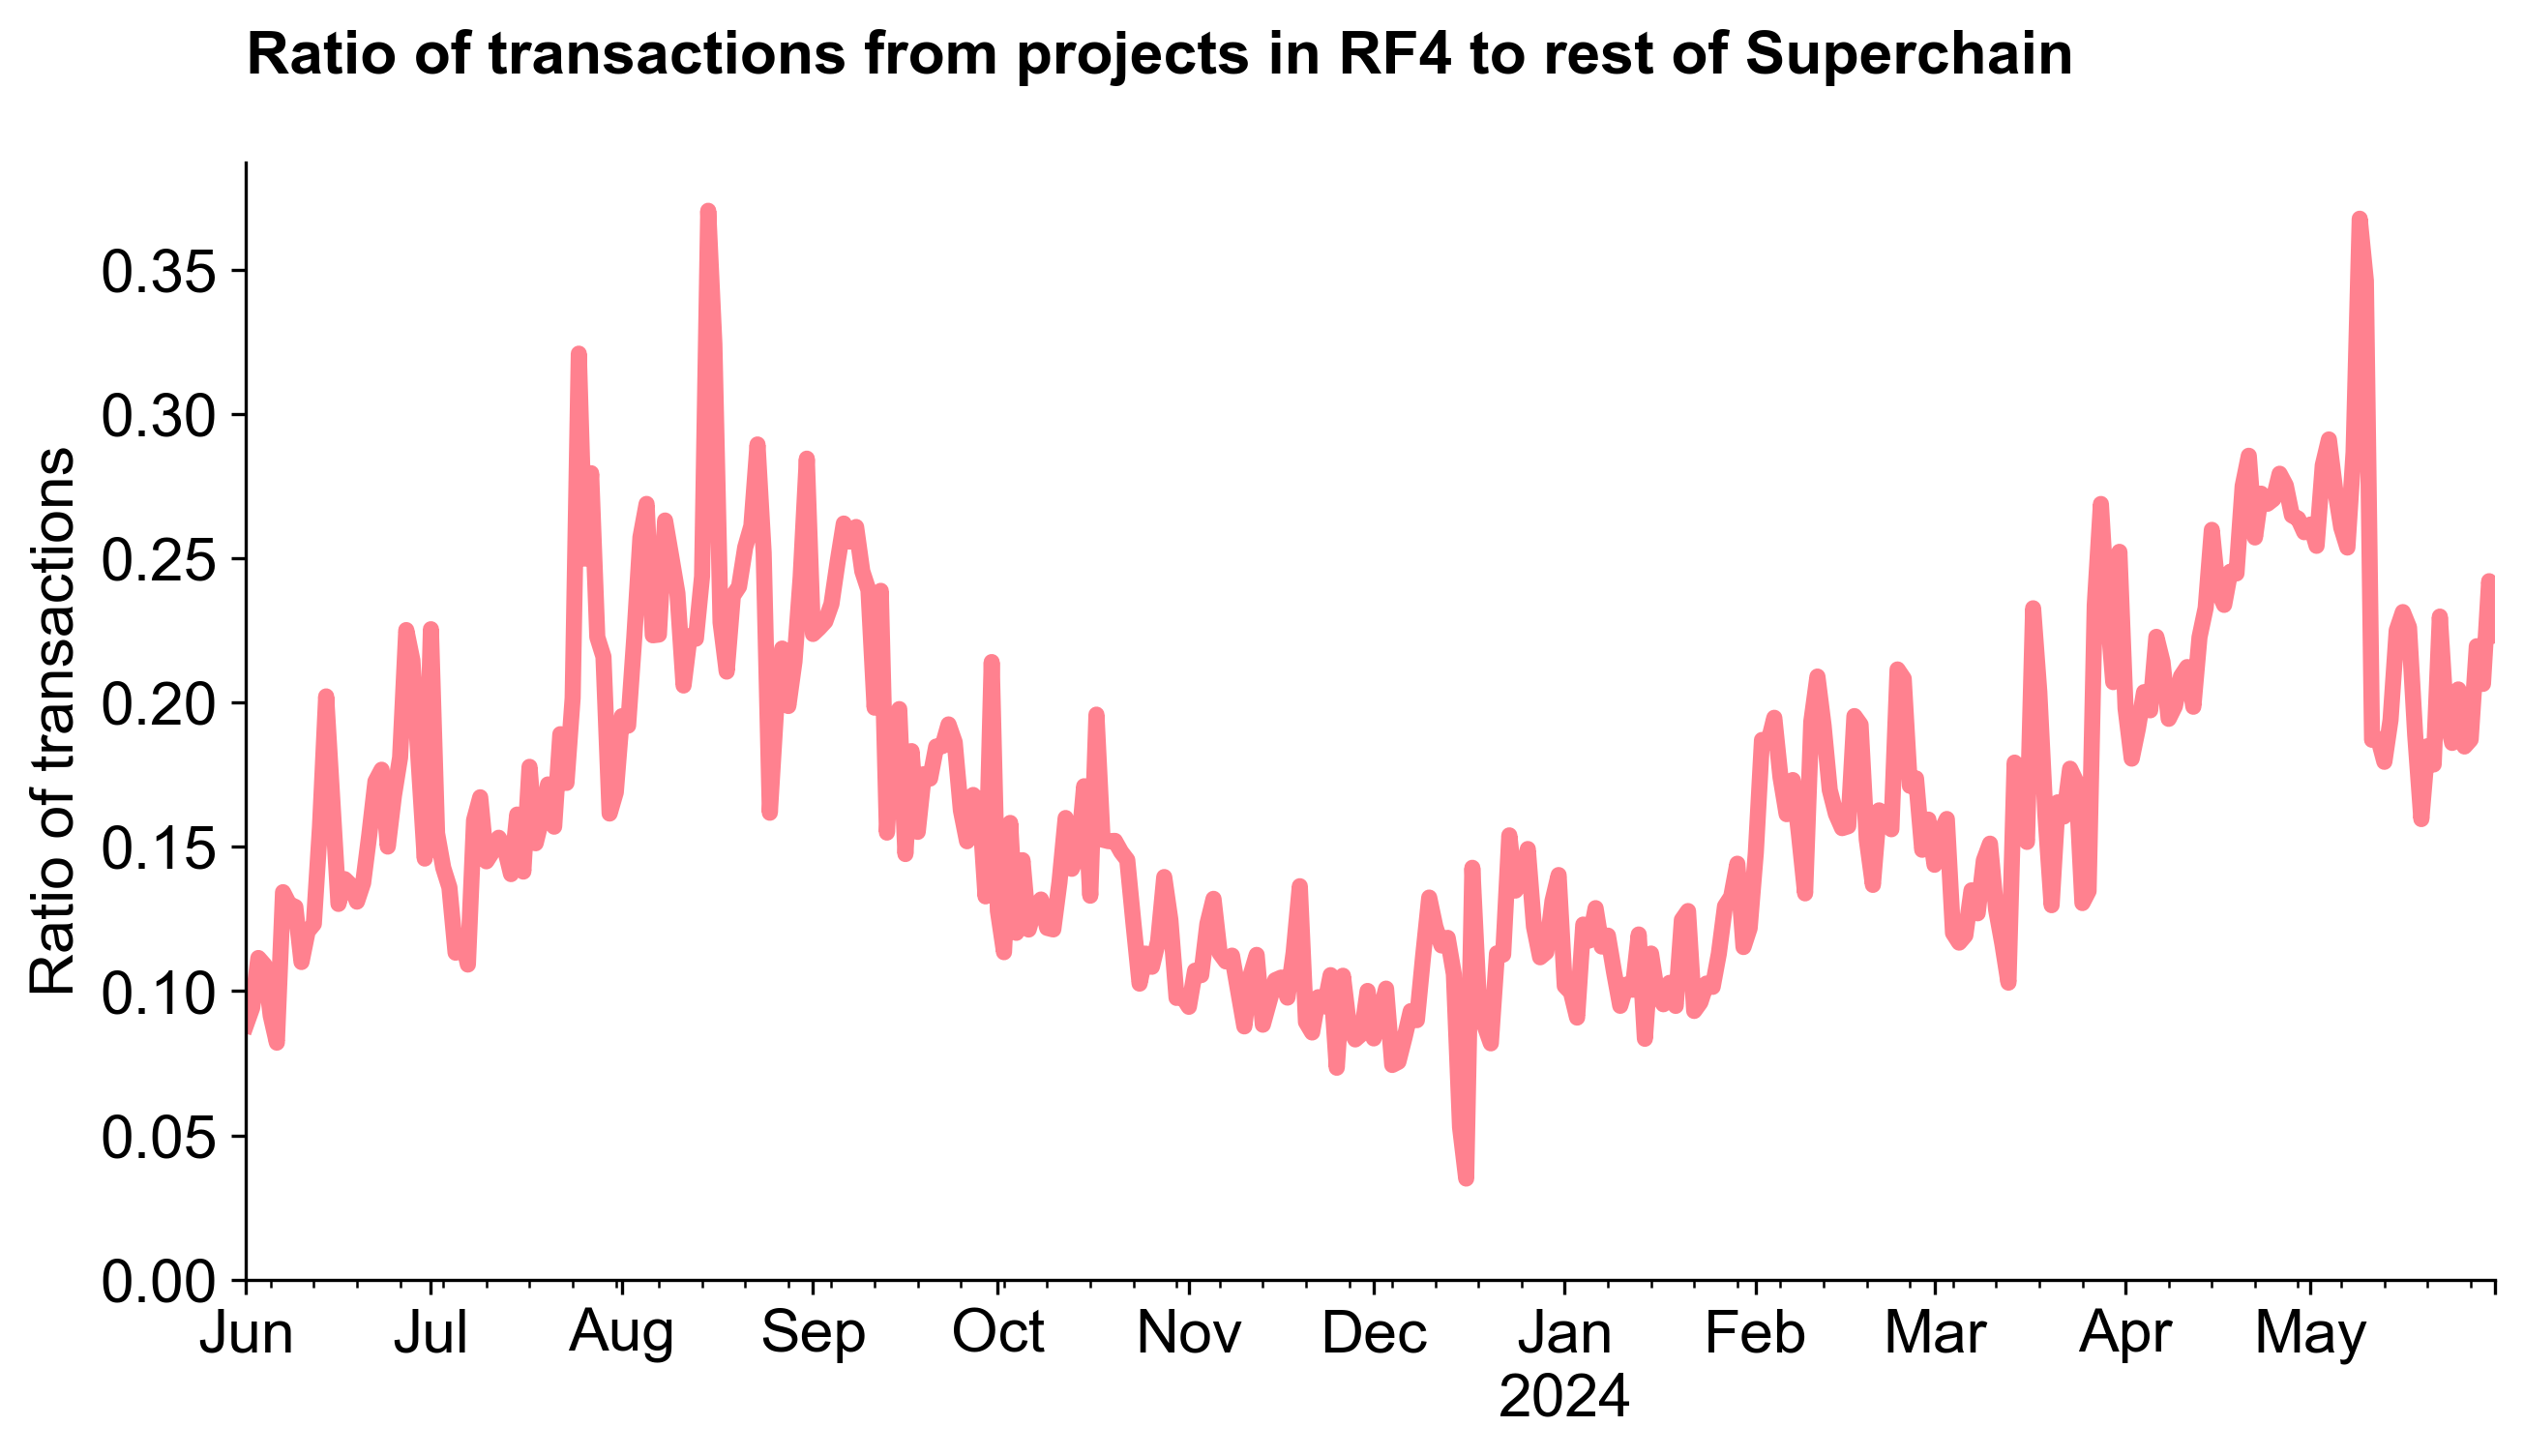

In [21]:
fig, ax = plt.subplots()
(rf4_txns / other_txns).plot(kind='line', color=COLOR1, alpha=.5, lw=4, ax=ax)
ax.set_ylim(0,)
ax.set_ylabel("Ratio of transactions")
ax.set_xlabel("")
ax.set_title("Ratio of transactions from projects in RF4 to rest of Superchain\n", loc='left', weight='bold')

Text(0.0, 1.0, 'Daily transactions for projects in RF4 vs other networks\n')

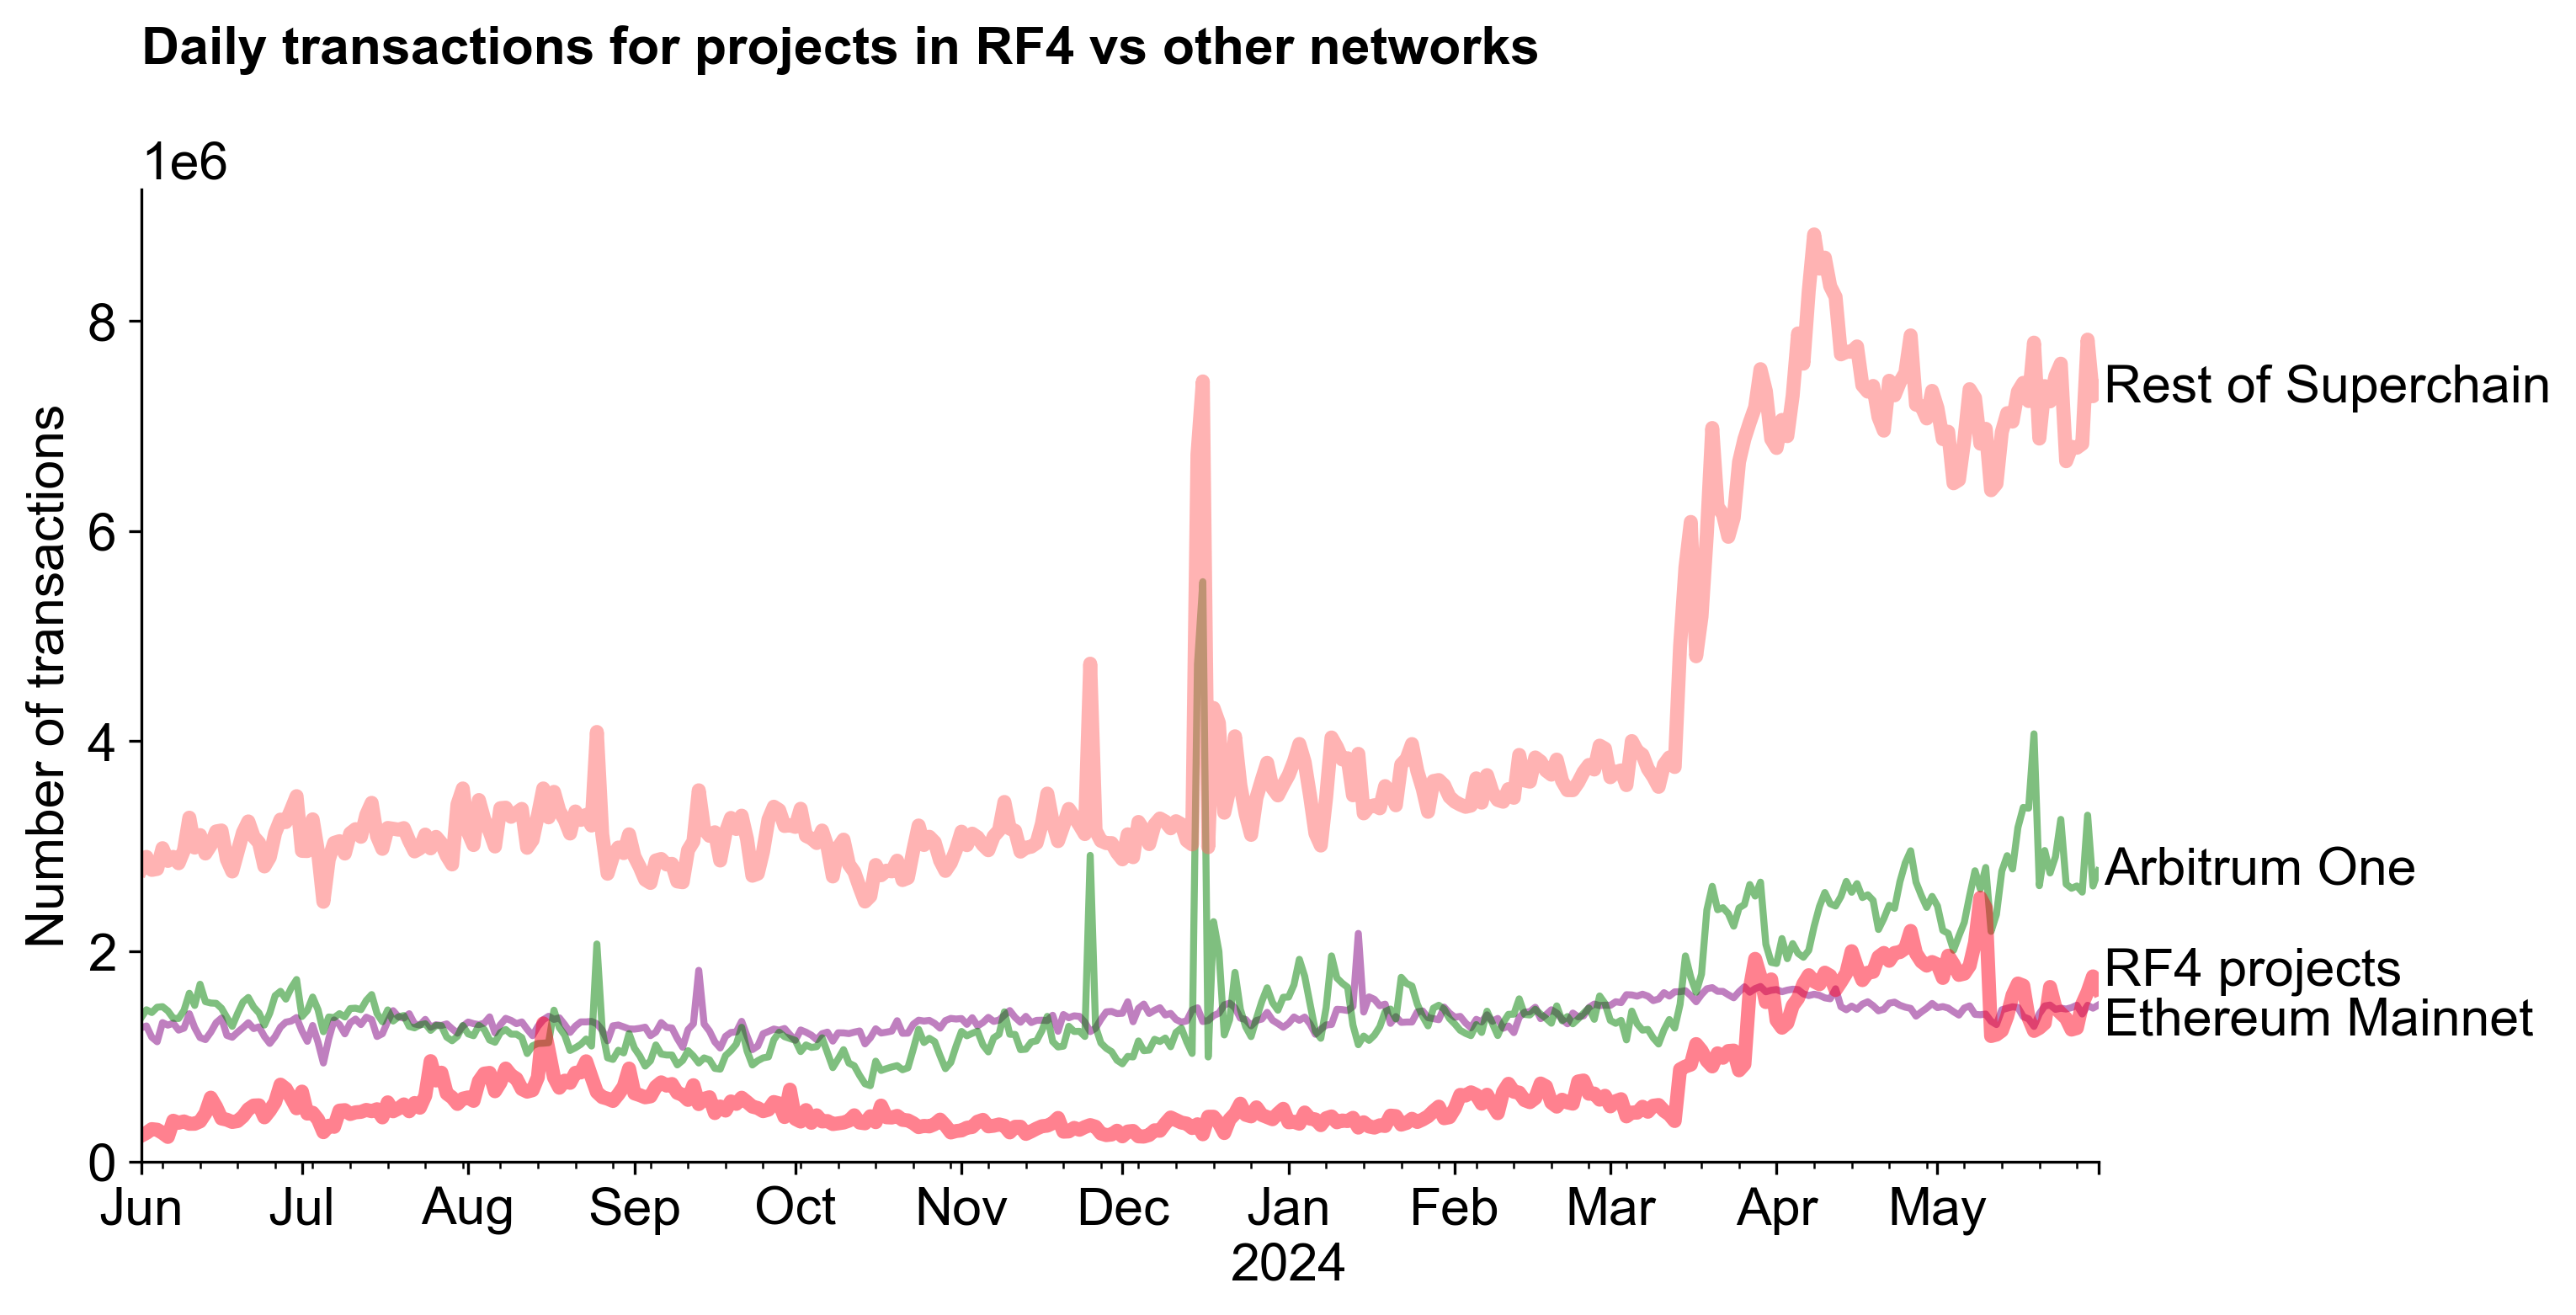

In [22]:
fig, ax = plt.subplots()

eth_txns = df_txns[df_txns['network'] == 'MAINNET'].groupby('bucket_day')['num_txns'].sum()
eth_txns.plot(kind='line', color='purple', alpha=.5, lw=2, ax=ax)

arb_txns = df_txns[df_txns['network'] == 'ARBITRUM'].groupby('bucket_day')['num_txns'].sum()
arb_txns.plot(kind='line', color='green', alpha=.5, lw=2, ax=ax)

rf4_txns = (
    df_txns[(df_txns['network'].isin(superchain_networks)) & df_txns['project_id'].isin(rf_projects)==True]
    .groupby('bucket_day')['num_txns'].sum()
)
rf4_txns.plot(kind='line', color=COLOR1, alpha=.5, lw=4, ax=ax)

other_txns = (
    df_txns[(df_txns['network'].isin(superchain_networks)) & df_txns['project_id'].isin(rf_projects)==False]
    .groupby('bucket_day')['num_txns'].sum()
)
other_txns.plot(kind='line', color=COLOR2, alpha=.5, lw=4, ax=ax)

xmax = ax.get_xlim()[-1]
ax.text(x=xmax+1, y=rf4_txns.iloc[-1]*1.1, s="RF4 projects", va='center', size=FONT_SIZE)
ax.text(x=xmax+1, y=other_txns.iloc[-1], s="Rest of Superchain", va='center', size=FONT_SIZE)
ax.text(x=xmax+1, y=eth_txns.iloc[-1]*.9, s="Ethereum Mainnet", va='center', size=FONT_SIZE)
ax.text(x=xmax+1, y=arb_txns.iloc[-1], s="Arbitrum One", va='center', size=FONT_SIZE)

ax.set_ylim(0,)
ax.set_ylabel("Number of transactions")
ax.set_xlabel("")
ax.set_title("Daily transactions for projects in RF4 vs other networks\n", loc='left', weight='bold')

## Going open source

This exhibit shows the rate of commit activity across 500+ OSS projects that have applied for Retro Funding since the first round. You can see a large number of projects open-sourced their code right before RF4.

In [23]:
events_df = (
    EVENTS_BY_PROJECT
    .query("event_type in ['COMMIT_CODE', 'CONTRACT_INVOCATION_SUCCESS_DAILY_COUNT']")
    .pivot_table(
        index='project_id',
        columns='event_type',
        values='bucket_month',
        aggfunc='min'
    )
    .dropna()
    .applymap(lambda x: pd.to_datetime(x.split()[0]))
    .rename(columns={
        'COMMIT_CODE': 'first_commit', 
        'CONTRACT_INVOCATION_SUCCESS_DAILY_COUNT': 'first_transaction'
    })
    .join(
        EVENTS_BY_PROJECT
        .query("event_type == 'CONTRACT_INVOCATION_SUCCESS_DAILY_COUNT'")
        .groupby('project_id')
        ['amount'].sum()
    )
    .reindex(collections['op-retrofunding-4'])
    .dropna()
    .reset_index()
)
events_df['timedelta'] = events_df['first_commit'] - events_df['first_transaction']
events_df['days'] = events_df['timedelta'].apply(lambda x: x.days)
events_df['project_name'] = events_df['project_id'].map(projects)
events_df['cohort'] = events_df['project_id'].map(project_cohort_mapping)
events_df.head()

project_id first_commit  \
0  iJQ0N668OiabXZhgIKbCjS33gmMyrLBmlGxCVqukajU=   2024-03-01   
1  LkLbL-gAhRtDeDt96SmzdRNqryw1t8MnHyfcXS-FlkM=   2024-04-01   
2  3QzXyGM15E_u8FH4SrJ5makJZbWGooAsjSo-ylicjSI=   2024-05-01   
3  yx9ny7gBmK3tOrUQi0iX0u7NS2lHADSWe4aYKs6RGZU=   2023-03-01   
4  gSNSfKjRbnqInKzb0X33PNfl2KcBb_geZNcaBrvysV0=   2023-08-01   

  first_transaction    amount timedelta  days        project_name  \
0        2024-01-01    1969.0   60 days    60      synonymfinance   
1        2023-10-01  266662.0  183 days   183           xswaplink   
2        2024-02-01   31903.0   90 days    90  elonsdev-blob-farm   
3        2023-08-01  215509.0 -153 days  -153        morphex-labs   
4        2023-12-01   10563.0 -122 days  -122             symm-io   

                  cohort  
0  First-time RF project  
1  First-time RF project  
2  First-time RF project  
3  First-time RF project  
4  First-time RF project

Text(0.5, 0, 'First public commit')

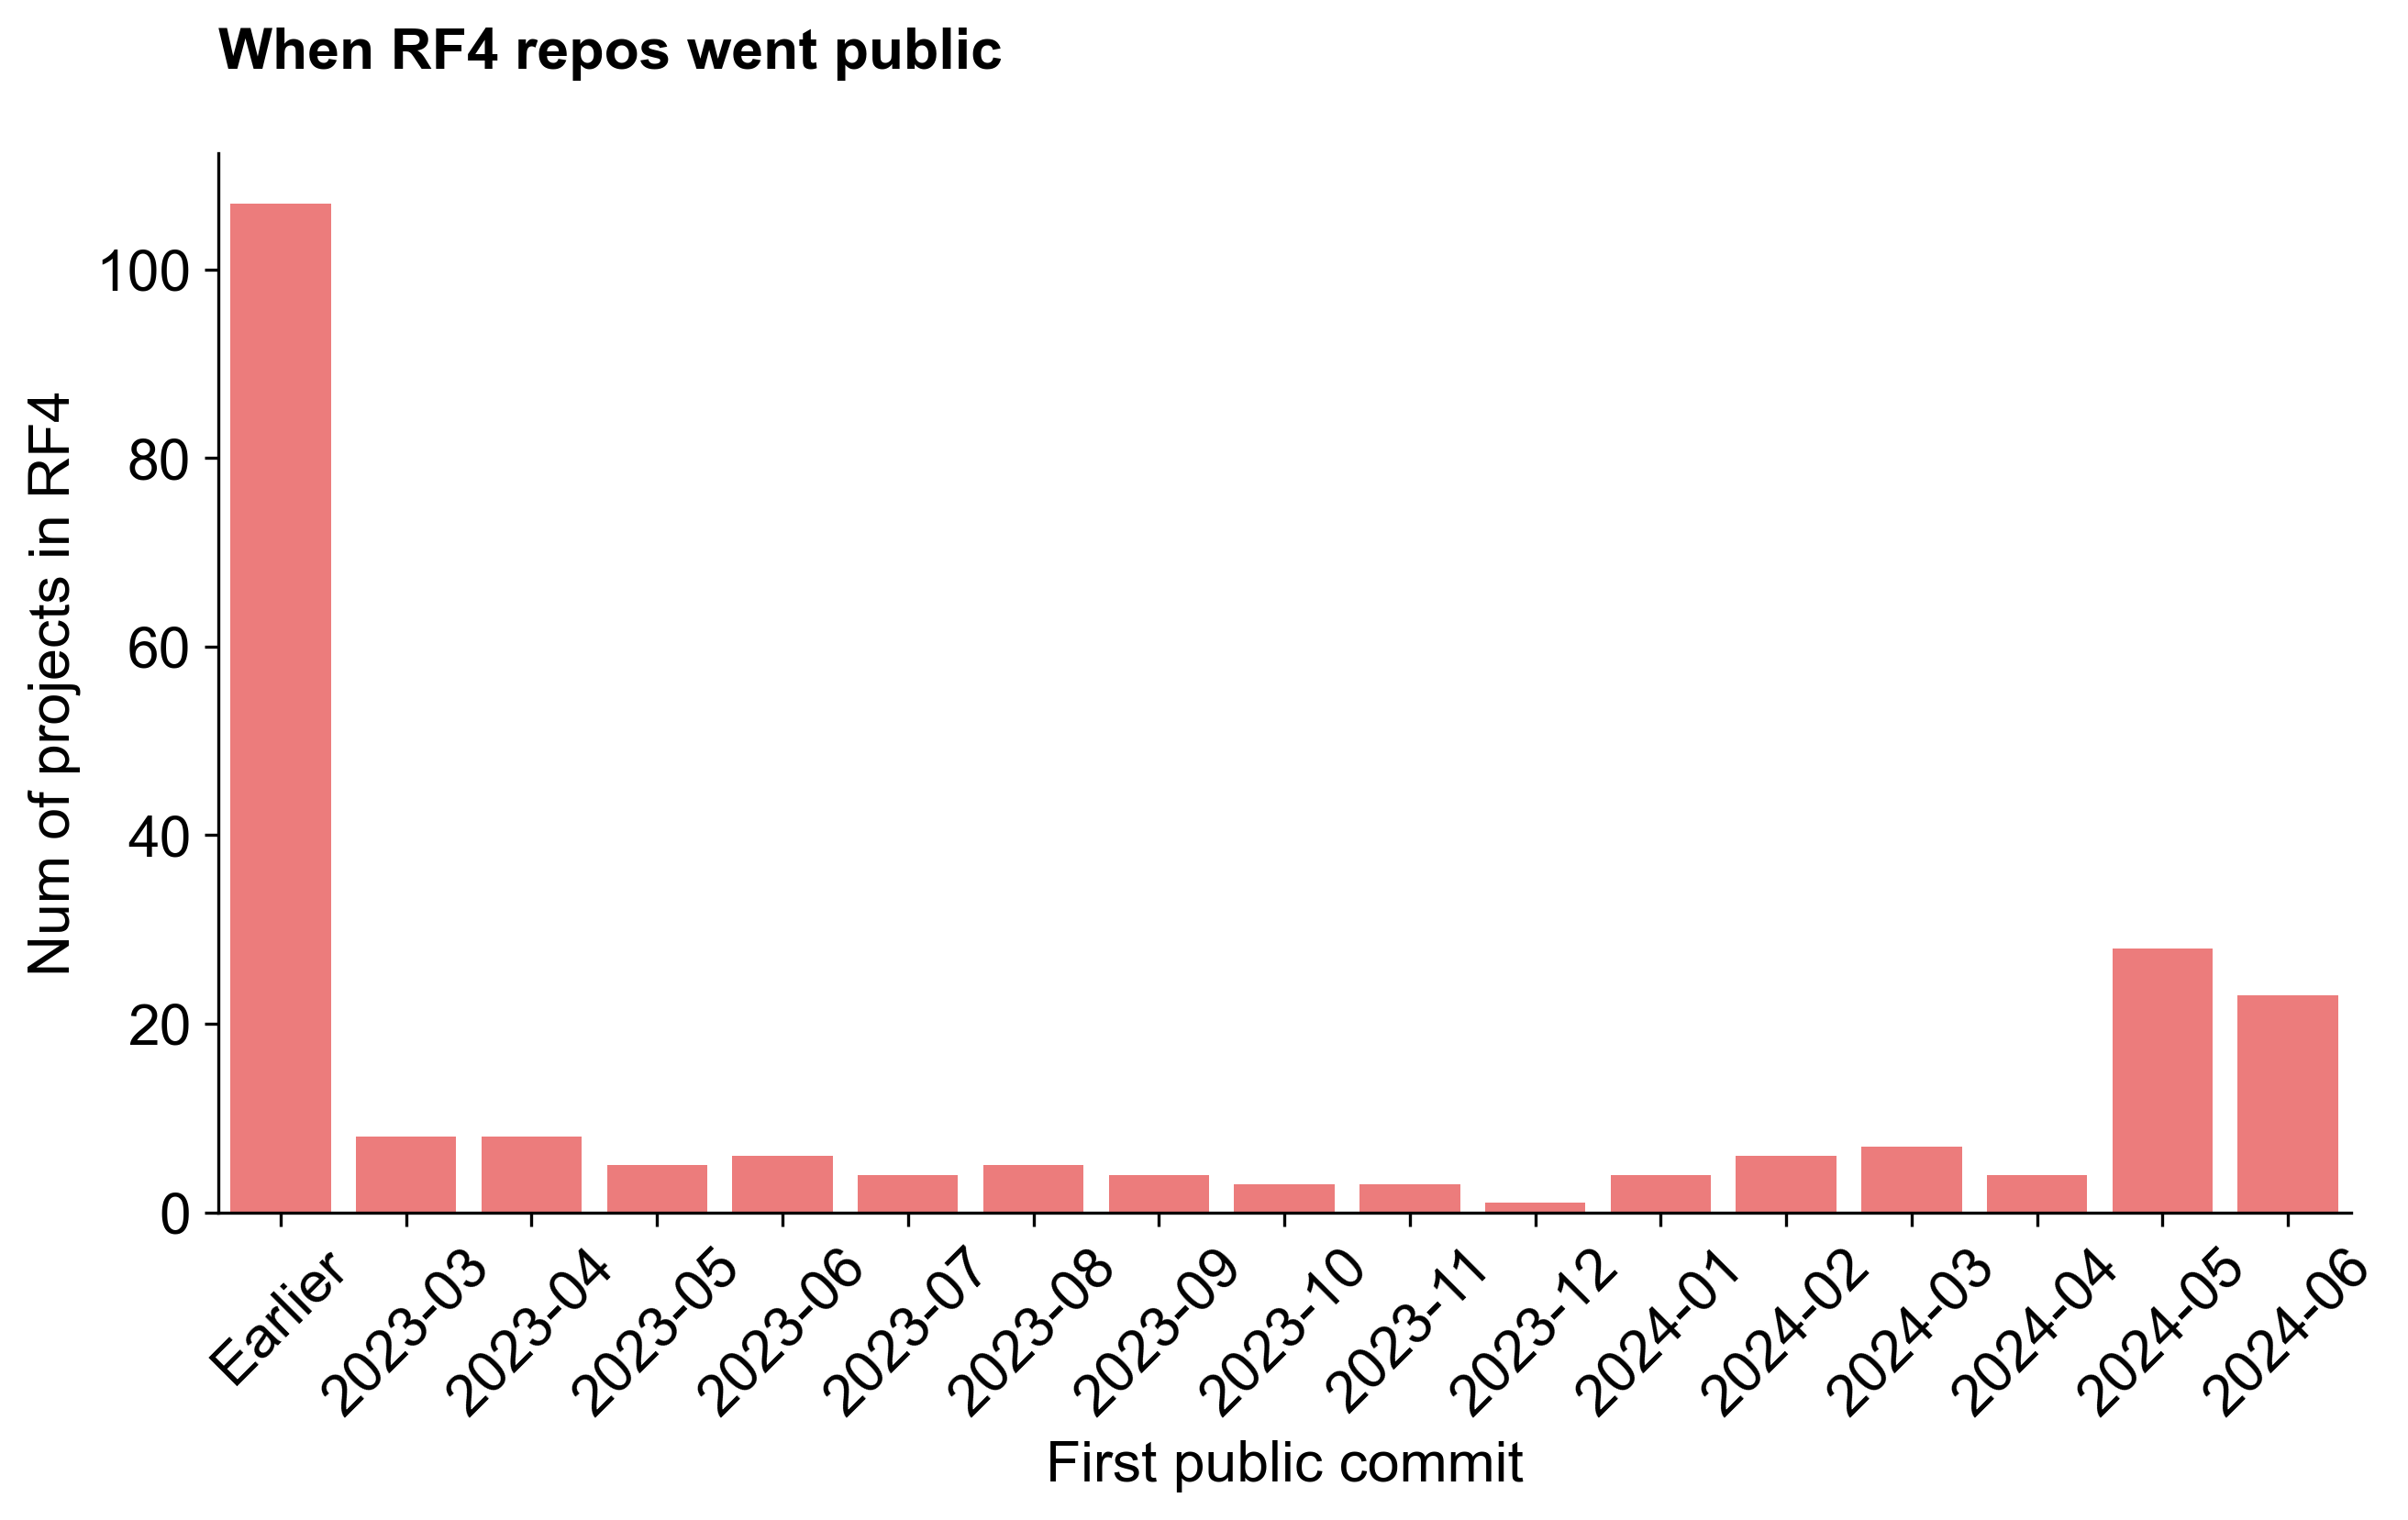

In [24]:
fig, ax = plt.subplots()

commit_history = (
    events_df[events_df['project_id'].isin(collections['op-retrofunding-4'])]
    .groupby('first_commit')['project_id']
    .count()
    .reset_index()
)

commit_history['first_commit'] = pd.to_datetime(commit_history['first_commit'])
sns.barplot(
    data=commit_history,
    x='first_commit',
    y='project_id',
    color=COLOR2,
    ax=ax
)

labels = [item.get_text() for item in ax.get_xticklabels()]
formatted_labels = [
    pd.to_datetime(label).strftime('%Y-%m')
    if i > 0
    else 'Earlier'
    for i,label in enumerate(labels)
]
ax.set_xticklabels(formatted_labels, rotation=45)
ax.set_title("When RF4 repos went public\n", loc='left', weight='bold')
ax.set_ylabel("Num of projects in RF4")
ax.set_xlabel("First public commit")

51 projects in RF4 made their first public commit after 2024-05-01
75 projects in RF4 had more than 10000 txns prior to RF3 voting but did not participate.


project_id first_commit  \
77   1JY9bwo0seIZ8CIP0iKDnoDyU34CT7YKT7ErEeO9B34=   2023-10-01   
38   _Fu7cQ3Cn6mE8Ybh0K0_tejumWmDWmqP2Mh6CpVI2Oc=   2023-04-01   
158  sbnlvN2OV8y140ijKiAr12nnhEkcKAYZyaxtOZOteqs=   2023-02-01   
123  kVeul81pcomlG3BHGnuKWAECfpCk_XLxN_AUgTWbkWo=   2023-02-01   
211  Mjx12gwAspKWigyP6Dg3FVwrRgxwxvXyvcfwrR7T-HY=   2023-02-01   
113  vwzZHbzGcRAjpZYFa21d_5E5_nDq0NHb1FyQmr1wF6o=   2023-02-01   
18   Pfx6e162v0aGiLBRdhFqt3AZ9OeML8ZD5ra3-EBbFcY=   2023-03-01   
62   2zEzY32slzJJWUyPMElMOWuczCBWRl7EZdeR8Kz8i-Q=   2023-02-01   
141  I1ULrUY9t789vj4akEP3lLgB9hmC1Unfg7875NEdWL0=   2023-02-01   
40   GVboljZKY6m9JBjDCnrT0lUfAe28t1W5UFNJRIH-xfY=   2023-02-01   
81   II6nyvQwat5x40RrExaTVYYqQ-KIdAA_yMWflxNbJKo=   2023-06-01   
23   5VkD5cN8xZtehiLcOgtLJsWoekAgzc5g8M5L5XWcsis=   2023-04-01   
207  tCWfRynYpmr1pMuaVTk9I2Uhz1RXZg05buXdRVDhTgw=   2023-02-01   
61   o7Tegl37mRn3t51qS50mf-ENGA98ACIQV01Ae_NWWf0=   2023-02-01   
12   7UvoYLwQcGamsUW0EDD7aipxdaT5to2z-FJ1P6kh-4k=   2023-02-01   
58   H1DdvseIeFYJUwYwfSNvsXvbgxfwasspZw2MT3Apkfg=   2023-02-01   
114  2rDMrpL2LxAp8HdLsctM08faEhDFO6b_OJT0yXJhV9I=   2023-09-01   
187  PZA75rAKiN4P9poFNpkZYK-yrF1r3WgpEHmbvwPjbXk=   2023-02-01   
219  xzWBwbu5eZ6QN5D04BxHfZcNq4-9_khDdWiMLYZKhXk=   2023-02-01   
86   UF36qYsUzfwX6GDNuWgpDXrqsmrLcK4Rw5D4hZY5Pxc=   2023-02-01   

    first_transaction      amount timedelta  days  \
77         2023-08-01   1375512.0   61 days    61   
38         2023-02-01   1570283.0   59 days    59   
158        2023-02-01   1720550.0    0 days     0   
123        2023-02-01   1767697.0    0 days     0   
211        2023-04-01   1910410.0  -59 days   -59   
113        2023-02-01   1989941.0    0 days     0   
18         2023-03-01   2516409.0    0 days     0   
62         2023-05-01   2715158.0  -89 days   -89   
141        2023-02-01   2749980.0    0 days     0   
40         2023-02-01   2924843.0    0 days     0   
81         2023-10-01   3108470.0 -122 days  -122   
23         2023-07-01   3206349.0  -91 days   -91   
207        2023-02-01   3357143.0    0 days     0   
61         2023-02-01   3501438.0    0 days     0   
12         2023-04-01   3840683.0  -59 days   -59   
58         2023-02-01   5116230.0    0 days     0   
114        2023-08-01   5511234.0   31 days    31   
187        2023-05-01  10241438.0  -89 days   -89   
219        2023-02-01  10396903.0    0 days     0   
86         2023-02-01  28657697.0    0 days     0   

                           project_name                 cohort  
77                           baseswapfi  First-time RF project  
38                           omni-x-nft  First-time RF project  
158                              across   Returning RF project  
123                               sushi   Returning RF project  
211                    debridge-finance  First-time RF project  
113                          woonetwork  First-time RF project  
18                              nfts2me  First-time RF project  
62                            holograph   Returning RF project  
141                           lifinance  First-time RF project  
40                           rabbithole   Returning RF project  
81                        dmailofficial  First-time RF project  
23                             odos-xyz  First-time RF project  
207                  perpetual-protocol  First-time RF project  
61                            0xproject  First-time RF project  
12   eth-infinitism-account-abstraction   Returning RF project  
58                            velodrome   Returning RF project  
114                   aerodrome-finance   Returning RF project  
187                                zora   Returning RF project  
219                    stargate-finance  First-time RF project  
86                           layer-zero  First-time RF project

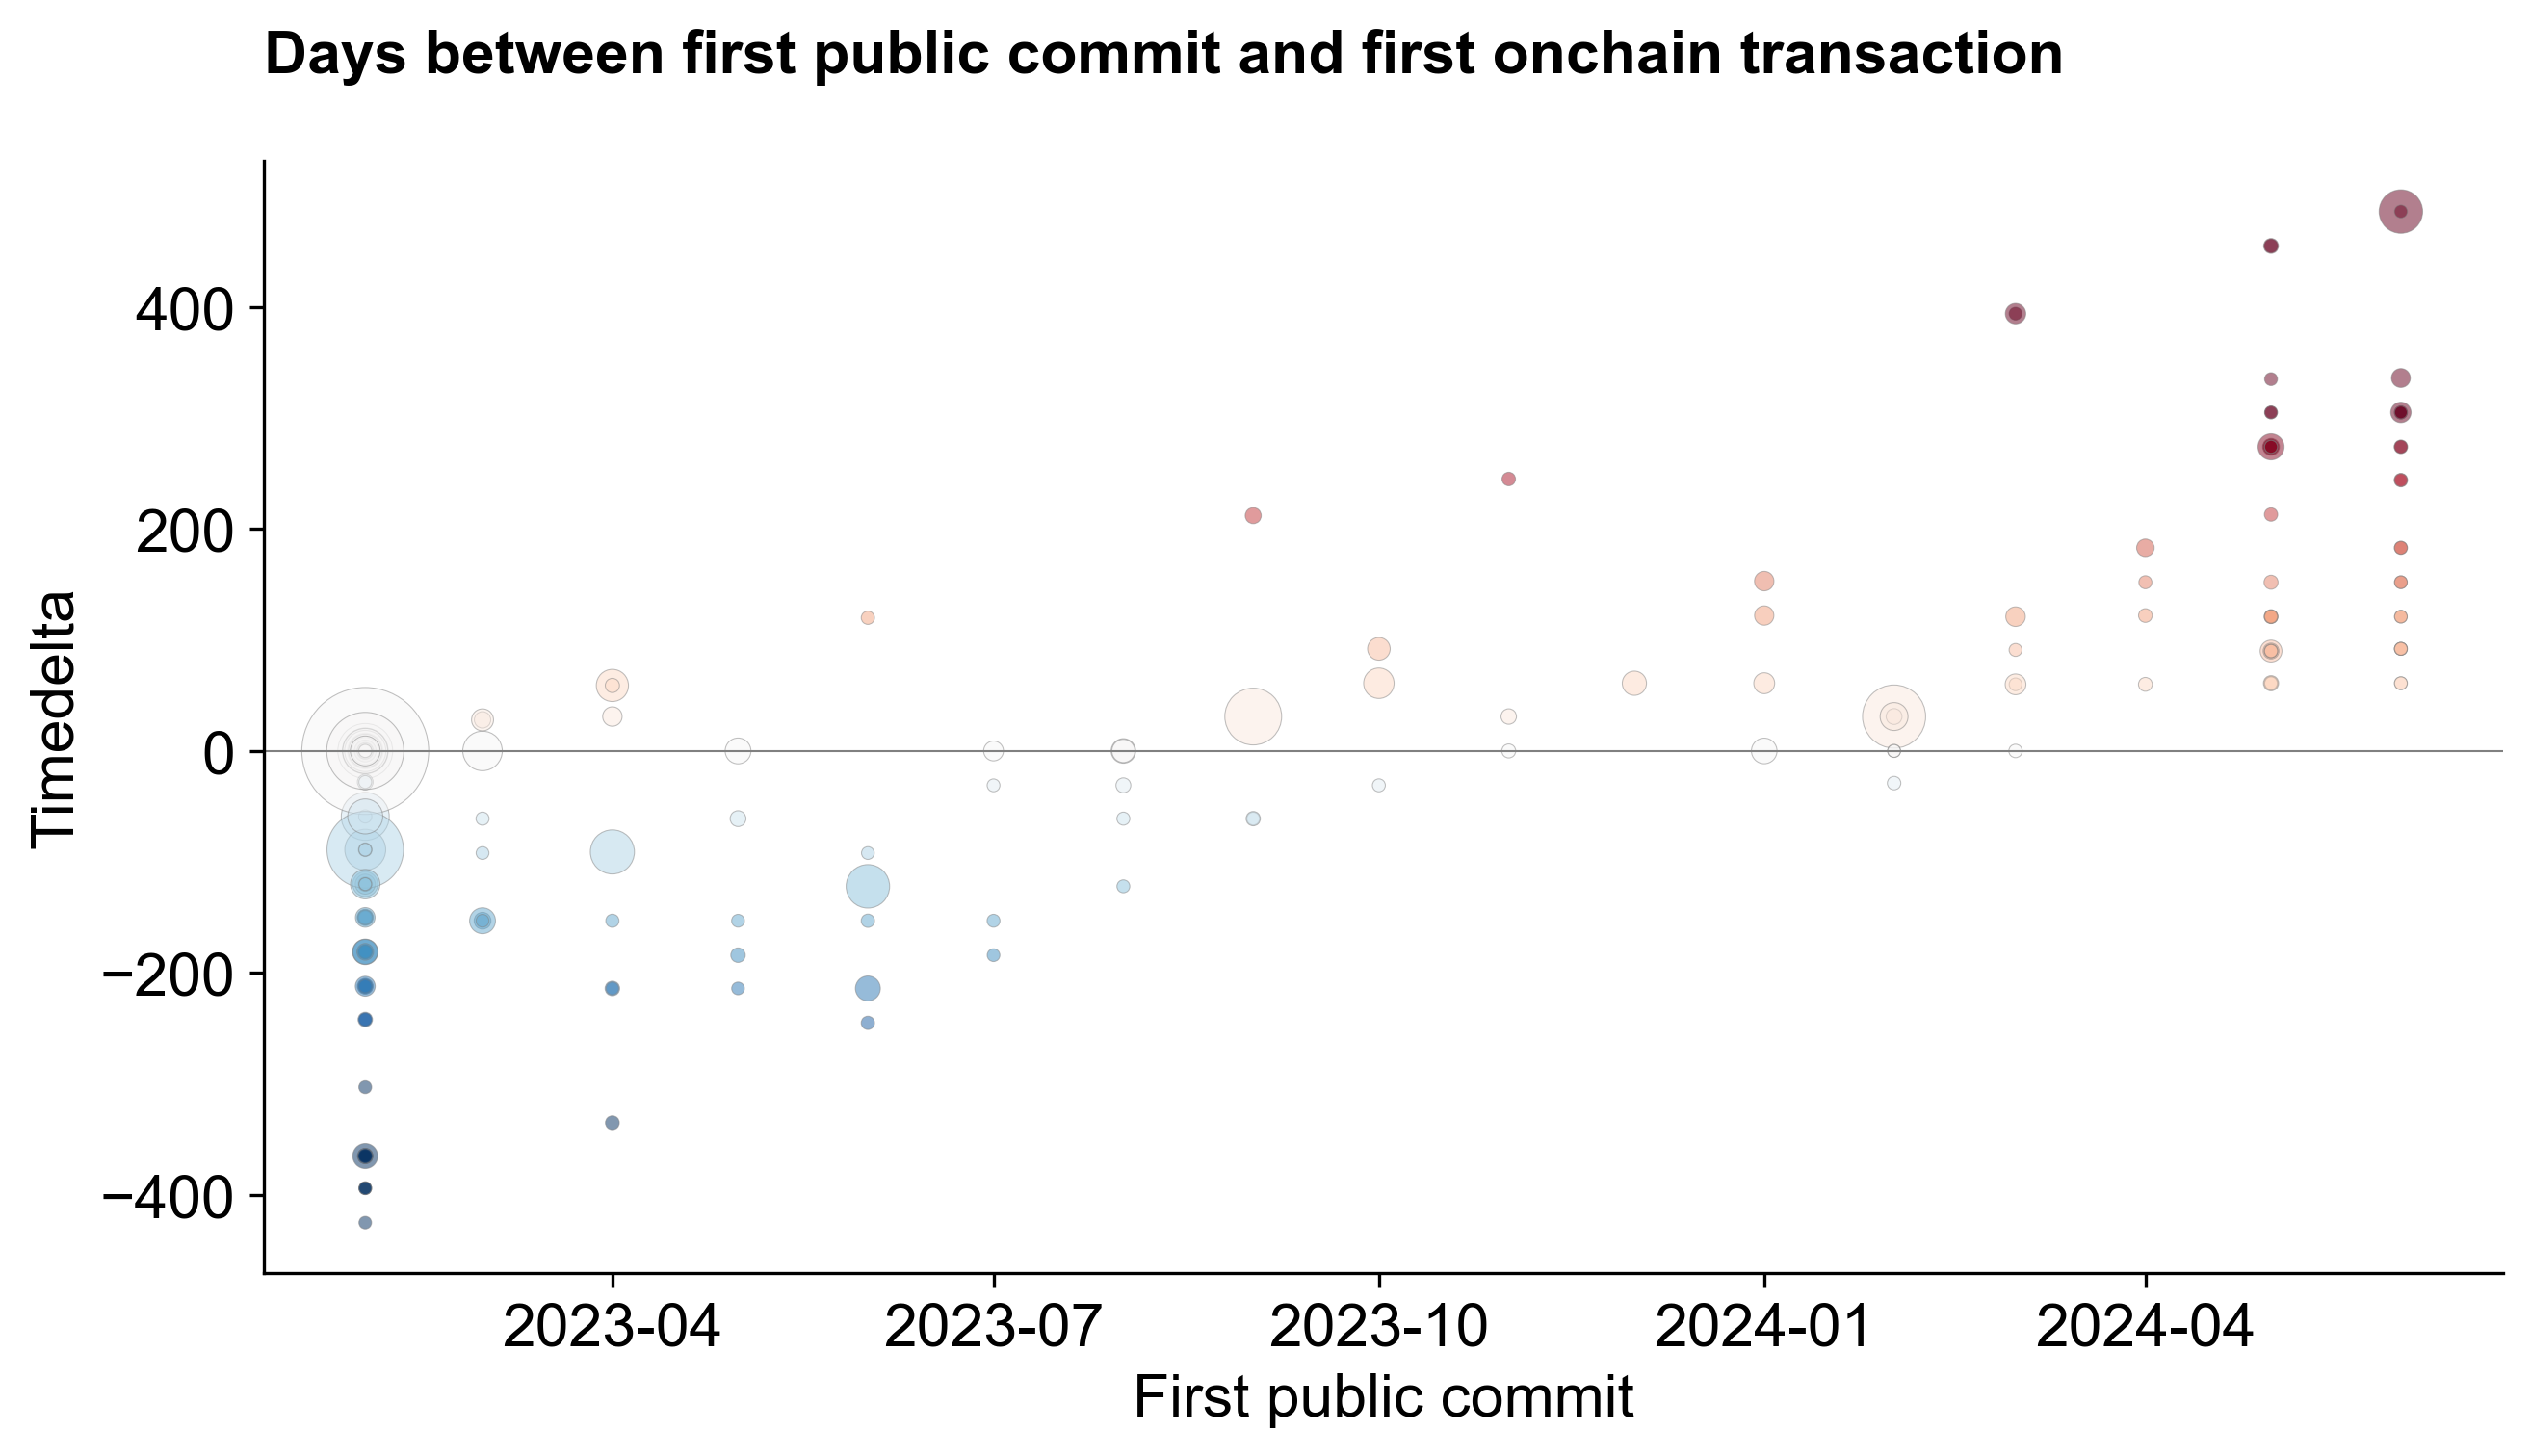

In [25]:
fig, ax = plt.subplots()
sns.scatterplot(
    data=events_df,
    x='first_commit',
    y='days',    
    size='amount',
    sizes=(10,1000),
    alpha=.5,
    hue='days',
    palette='RdBu_r',
    hue_norm=(-300,300),
    edgecolor='gray',
    legend=False,
    ax=ax
)
ax.axhline(y=0, color='gray', lw=.5)
ax.set_title("Days between first public commit and first onchain transaction\n", loc='left', weight='bold')
ax.set_ylabel("Timedelta")
ax.set_xlabel("First public commit")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

rf4_date = pd.to_datetime('2024-05-01')
late_commits = len(events_df[(events_df['days'] > 30) & (events_df['first_commit'] >= rf4_date)])
print(f"{late_commits} projects in RF4 made their first public commit after 2024-05-01")

rf3_apps = pd.to_datetime('2023-11-07')
early_txns = events_df[
    (events_df['first_commit'] < rf3_apps) 
    & (events_df['first_transaction'] < rf3_apps) 
    & (events_df['amount']>10000)
]
missing_cohort = set(early_txns['project_id']).difference(collections['op-rpgf3'])
print(f"{len(missing_cohort)} projects in RF4 had more than 10000 txns prior to RF3 voting but did not participate.")
early_txns.sort_values(by='amount').tail(20)

# Bonus: Developer Activity Heatmap

In [26]:
from contribution_heatmap import contribution_heatmap

hm = (
    dev_df[dev_df['cohort'] != 'Never received RF']
    .groupby(['project_id', 'project_name', 'bucket_month'])['fulltime_active_dev']
    .sum()
    .reset_index()
)

hm['bucket_month'] = hm['bucket_month'].apply(lambda x: str(x).split(' ')[0][:-3])
top_200 = hm.groupby('project_name')['fulltime_active_dev'].mean().sort_values().tail(200).index
hm = hm[hm['project_name'].isin(top_200)]

def create_label(pid):
    rf_cohort_list = ['op-rpgf1', 'op-rpgf2', 'op-rpgf3', 'op-retrofunding-4']
    cohort_nums = sorted([c[-1] for c in rf_cohort_list if pid in collections[c]])
    return f"{projects[pid]} • RF{'/'.join(cohort_nums)}"
hm['project_label'] = hm['project_id'].apply(create_label)
    
contribution_heatmap(
    dataframe=hm,
    index_col='project_label',
    column_col='bucket_month',
    value_col='fulltime_active_dev',
    sort_label_method='mean',
    linewidths=.1,
    figsize=(10,60),
)

(<Figure size 3000x18000 with 1 Axes>, <Axes: >)

In [27]:
by_cohort = (
    df_txns[(df_txns['superchain'] == True) & (df_txns['is_rf4'] == True) & (df_txns['6_month_interval'] == '2023-12 to 2024-05')]
).groupby('cohort')['num_txns'].sum()

In [28]:
by_cohort['First-time RF project'] / by_cohort.sum()

0.535631589148203